## Introduction

Peer-to-peer (P2P) lending represents an innovative method of peer-to-peer money lending, facilitated through online platforms. This study employs real-world data obtained from "Lending Club," an American-based company, to predict credit solvency(Binary Classification) using various predictive models and techniques, including Lasso, Ridge, Elastic-Net, Logistic Regression, Extreme Gradient Boosting, and Bayesian Additive Regression Trees (BART). Through an economic evaluation of the context and the results obtained from the models, this study aims to draw conclusions regarding credit risk assessment in the P2P lending market.

The original data set is large: 1.6 GB csv file. It was scraped from the Lending Club website by some guy on github.
We downloaded it from kaggle:
 https://www.kaggle.com/datasets/wordsforthewise/lending-club?select=accepted_2007_to_2018Q4.csv.gz

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 150

In [3]:
path= "..\\..\\lending_club_large\\accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv"
df = pd.read_csv(path, low_memory = False)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB
None


Before dropping the columns that contain information about loan payments, we calculate the average payment for a defaulted loan as a percentage of loan principal

In [4]:
default_pymnt_pct = (df.total_pymnt/df.loan_amnt)[df.loan_status.isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off'])].mean()
default_pymnt_pct

0.54123379101107

On average loans that default pay back 54% of the principal

We also calculate the average payment as percentage of loan amount for loans that did not default

In [5]:
non_default_pymnt_pct = (df.total_pymnt/df.loan_amnt)[~df.loan_status.isin(['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off',"Current"])].mean()
print(non_default_pymnt_pct)
(1-default_pymnt_pct)/(non_default_pymnt_pct-1)


1.1378077260616586


3.3290311225632343

We see that on average to make up for the payment losses of one defaulted loan 3.33 non defaulted loans are needed

In [6]:
#selecting the variables of our interest
cols_to_keep = [
    "annual_inc","application_type","dti","earliest_cr_line","emp_length","fico_range_high","fico_range_low","grade",
    "home_ownership","inq_last_6mths","installment","int_rate","issue_d","loan_amnt","loan_status","mo_sin_rcnt_tl",
    "mort_acc","mths_since_recent_bc","disbursement_method","verification_status","term","tax_liens","sub_grade",
    "purpose","pub_rec_bankruptcies","percent_bc_gt_75","num_bc_tl","num_actv_rev_tl","num_actv_bc_tl","num_accts_ever_120_pd",
    "acc_now_delinq","acc_open_past_24mths","open_acc","pct_tl_nvr_dlq","pub_rec","total_acc","total_bal_ex_mort"
]

df = df[cols_to_keep]
df.dropna(inplace = True)
df.reset_index(inplace = True, drop = True)


Most of the columns we removed had NAs on a large portion of the dataset.
Also some columns already contained information on the loan default like total payment.

The features we kept have information on the borrower's income, employment, previous credit history, on the loan interest, purpose, duration.

The loan_status variable is the target feature of our analysis

In [7]:
df.loan_status.value_counts()

loan_status
Fully Paid            953502
Current               803484
Charged Off           234903
Late (31-120 days)     19341
In Grace Period         7745
Late (16-30 days)       3853
Default                   33
Name: count, dtype: int64

We need to group it into two classes: default = 1 and default = 0

Also we will drop current loans, since at the time the data was scraped from Lending Club website it wasn't known if the loan defaulted or not.

In [8]:
df = df[df.loan_status != "Current"] #dropping current loans

default_categories = ['Default', 'Charged Off', 'Does not meet the credit policy. Status:Charged Off']
loan_status_dummy = df.loan_status.isin(default_categories).astype("uint8")
df.loan_status = loan_status_dummy

df.reset_index(inplace = True, drop = True)

## Variables' descriptions

In [9]:
pd.set_option("display.max_colwidth",300)
description =  pd.read_csv("description_col.csv",index_col="Nome_Variabile")
description

Descrizione  \
Nome_Variabile                                                                                                                                                                                                                              
annual_inc                                                                                                                                      The combined self-reported annual income provided by the co-borrowers during registration   
application_type                                                                                                                     Indicates whether the loan is an individual application or a joint application with two co-borrowers   
dti                    A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income   
earliest_cr_line                                                                                                                                                  Earliest credit line at time of application for the secondary applicant   
emp_length                                                                                             Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.    
fico_range_high                                                                                                                                              The upper boundary range the borrower’s FICO at loan origination belongs to.   
fico_range_low                                                                                                                                               The lower boundary range the borrower’s FICO at loan origination belongs to.   
grade                                                                                                                                                                                                              LC assigned loan grade   
home_ownership                                                                      The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER   
inq_last_6mths                                                                                                                                           The number of inquiries in past 6 months (excluding auto and mortgage inquiries)   
installment                                                                                                                                                              The monthly payment owed by the borrower if the loan originates.   
int_rate                                                                                                                                                                                                        Interest Rate on the loan   
issue_d                                                                                                                                                                                               The month which the loan was funded   
loan_amnt                                                    The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.   
loan_status                                                                                                                                                                                                    Current status of the loan   
mo_sin_rcnt_tl                                                                                                                                                                                   

## Data visualisation


We will start with numeric, continuous variables

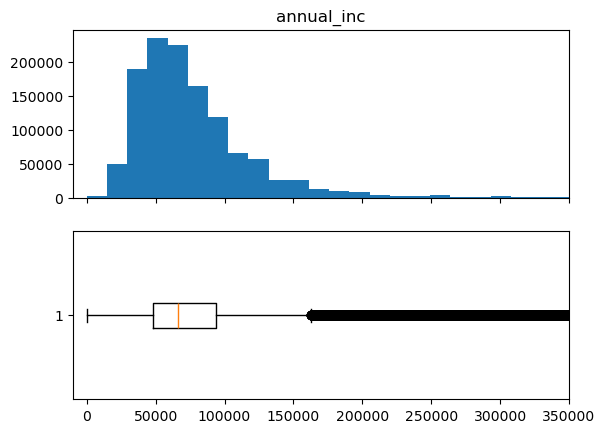

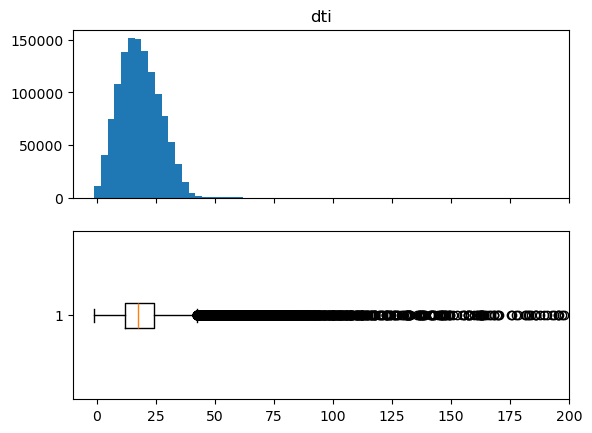

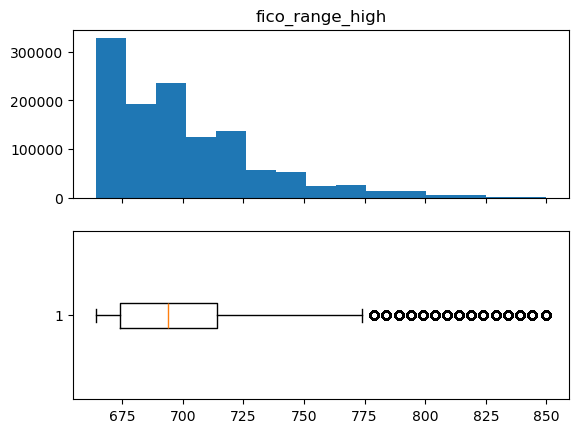

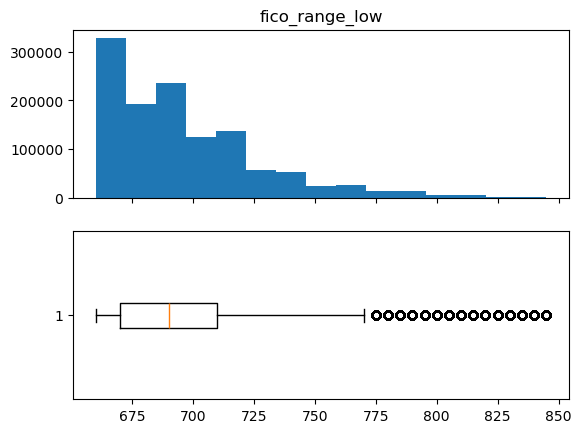

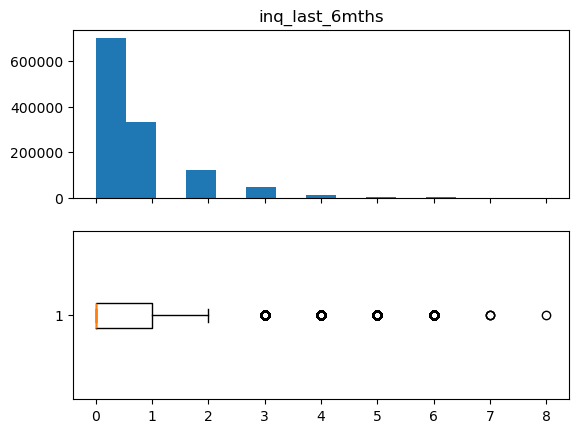

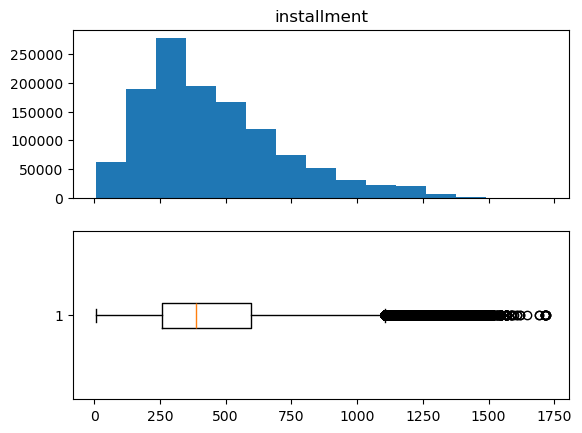

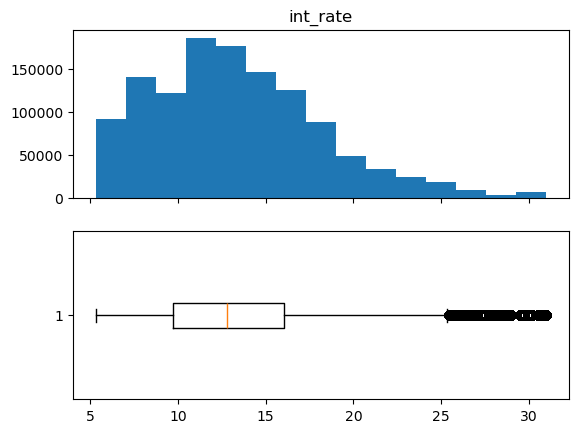

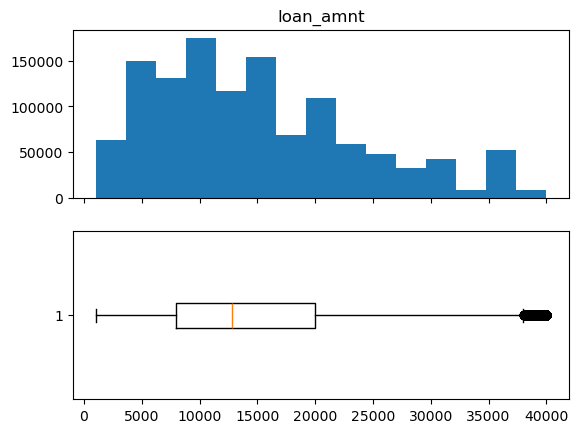

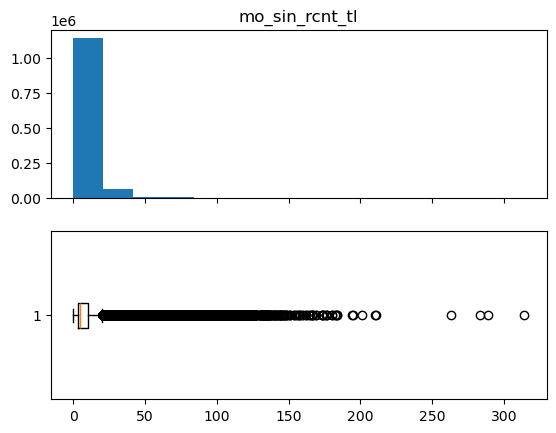

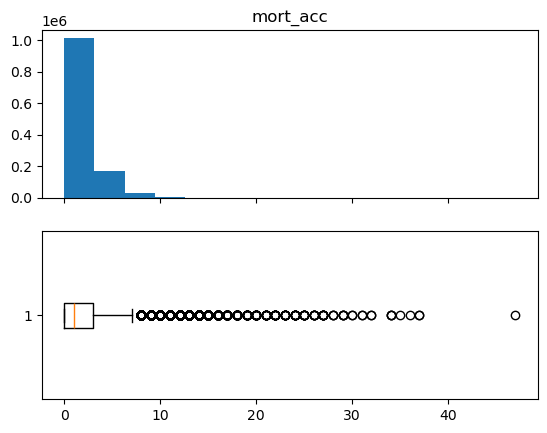

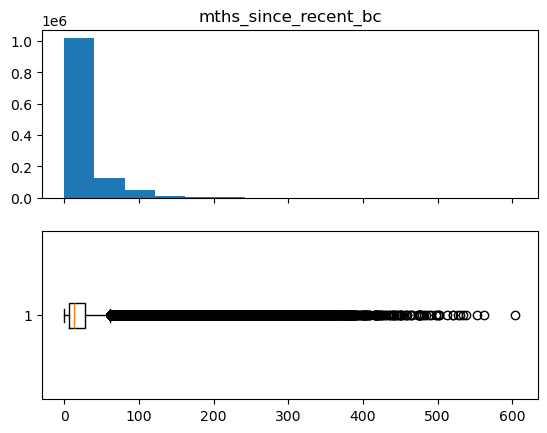

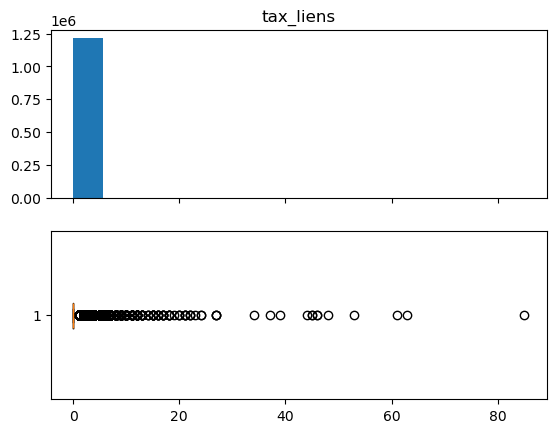

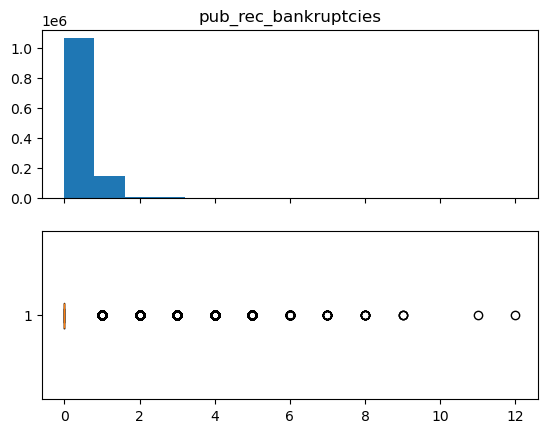

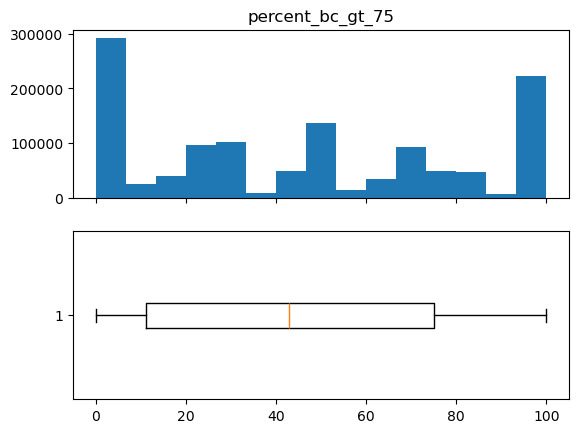

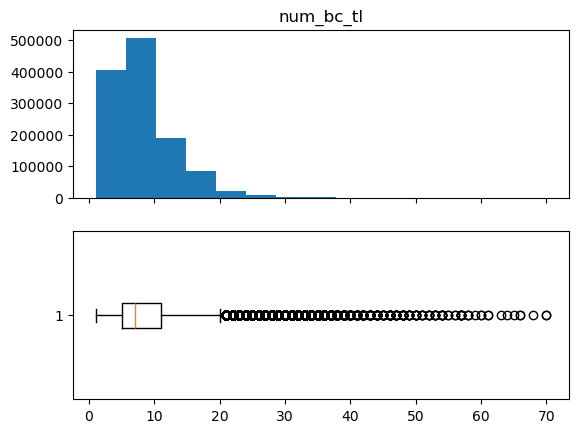

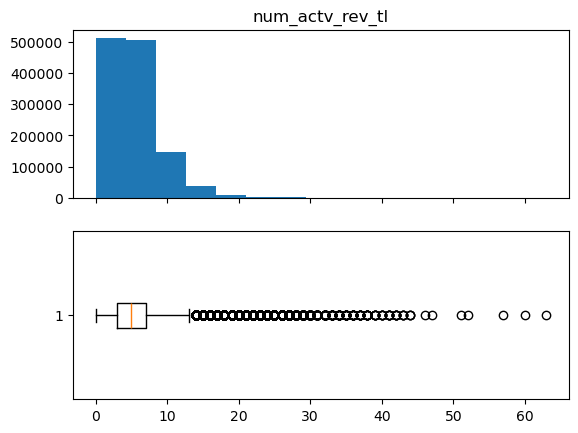

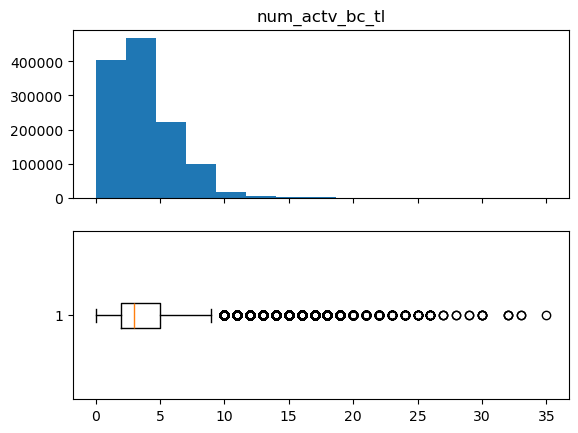

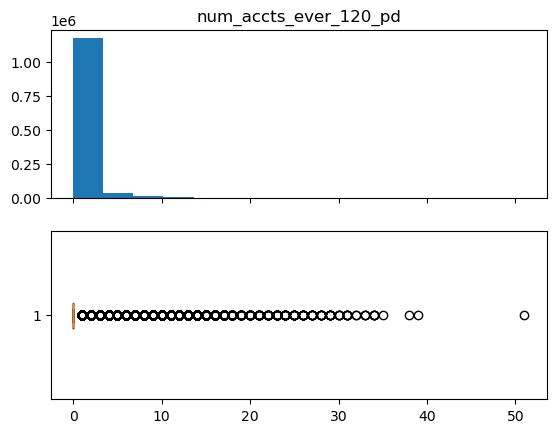

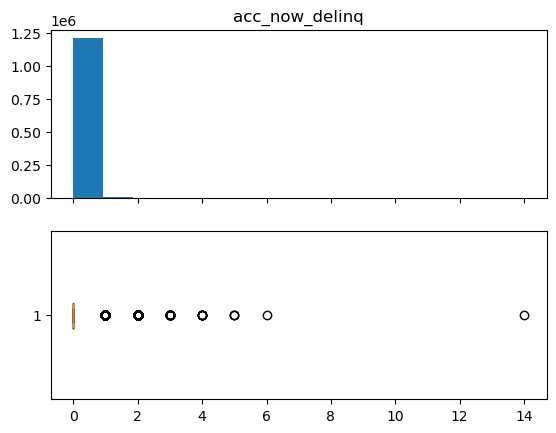

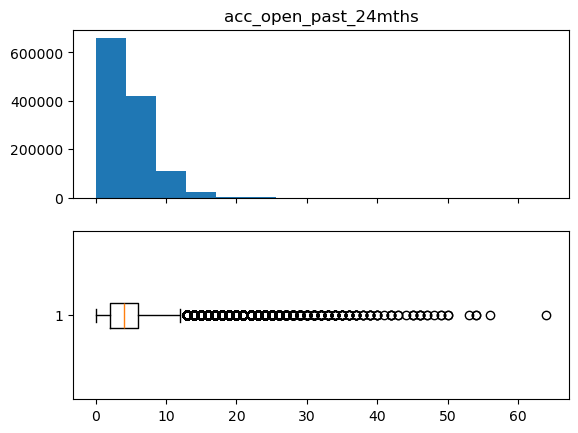

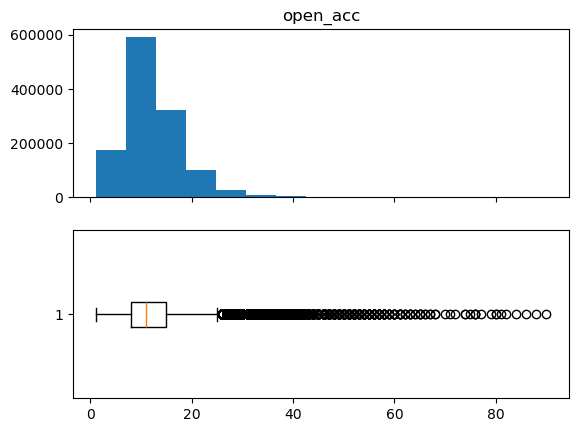

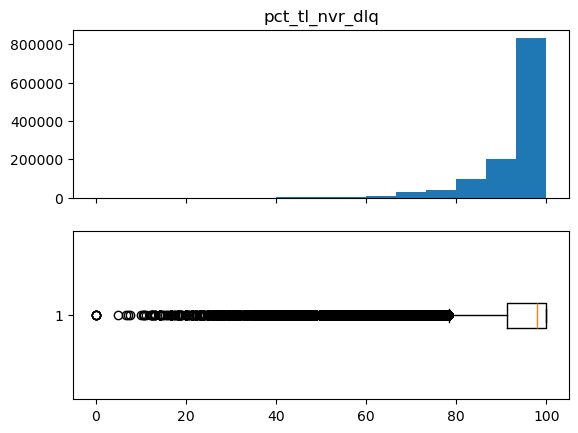

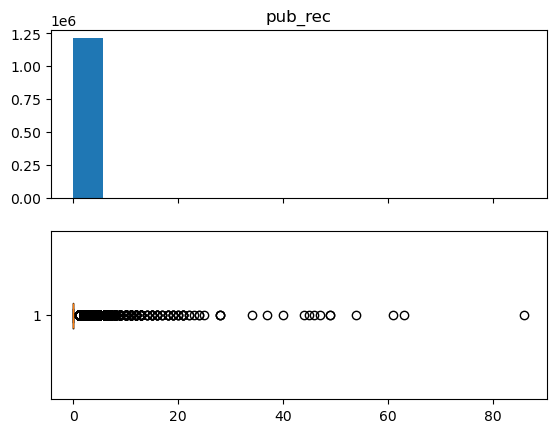

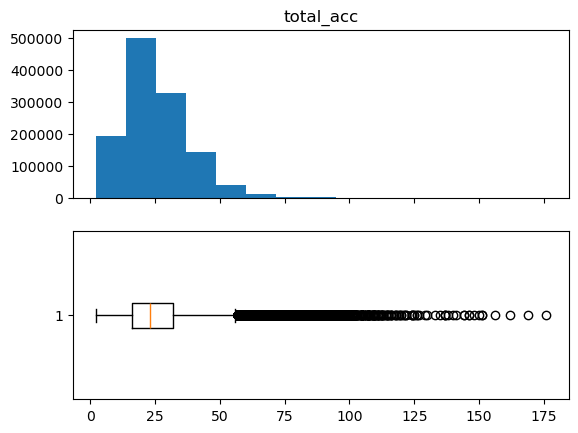

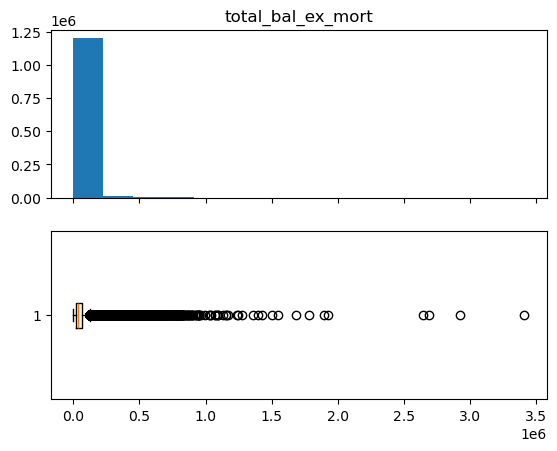

In [10]:
numeric_vars = df.columns[df.dtypes == "float64"]

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.hist(df["annual_inc"], bins = 750)
ax2.boxplot(df["annual_inc"], vert = False)
ax1.set_title("annual_inc")
ax1.set_xlim(-10000, 350000)
ax2.set_xlim(-10000, 350000)
plt.show()

fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
ax1.hist(df["dti"], bins = 350)
ax2.boxplot(df["dti"], vert = False)
ax1.set_title("dti")
ax1.set_xlim(-10, 200)
ax2.set_xlim(-10, 200)
plt.show()

for var in numeric_vars:
    if var not in ["annual_inc","dti"]:
        fig, (ax1, ax2) = plt.subplots(2,1,sharex=True)
        ax1.hist(df[var], bins = 15)
        ax2.boxplot(df[var], vert = False)
        ax1.set_title(var)
        plt.show()

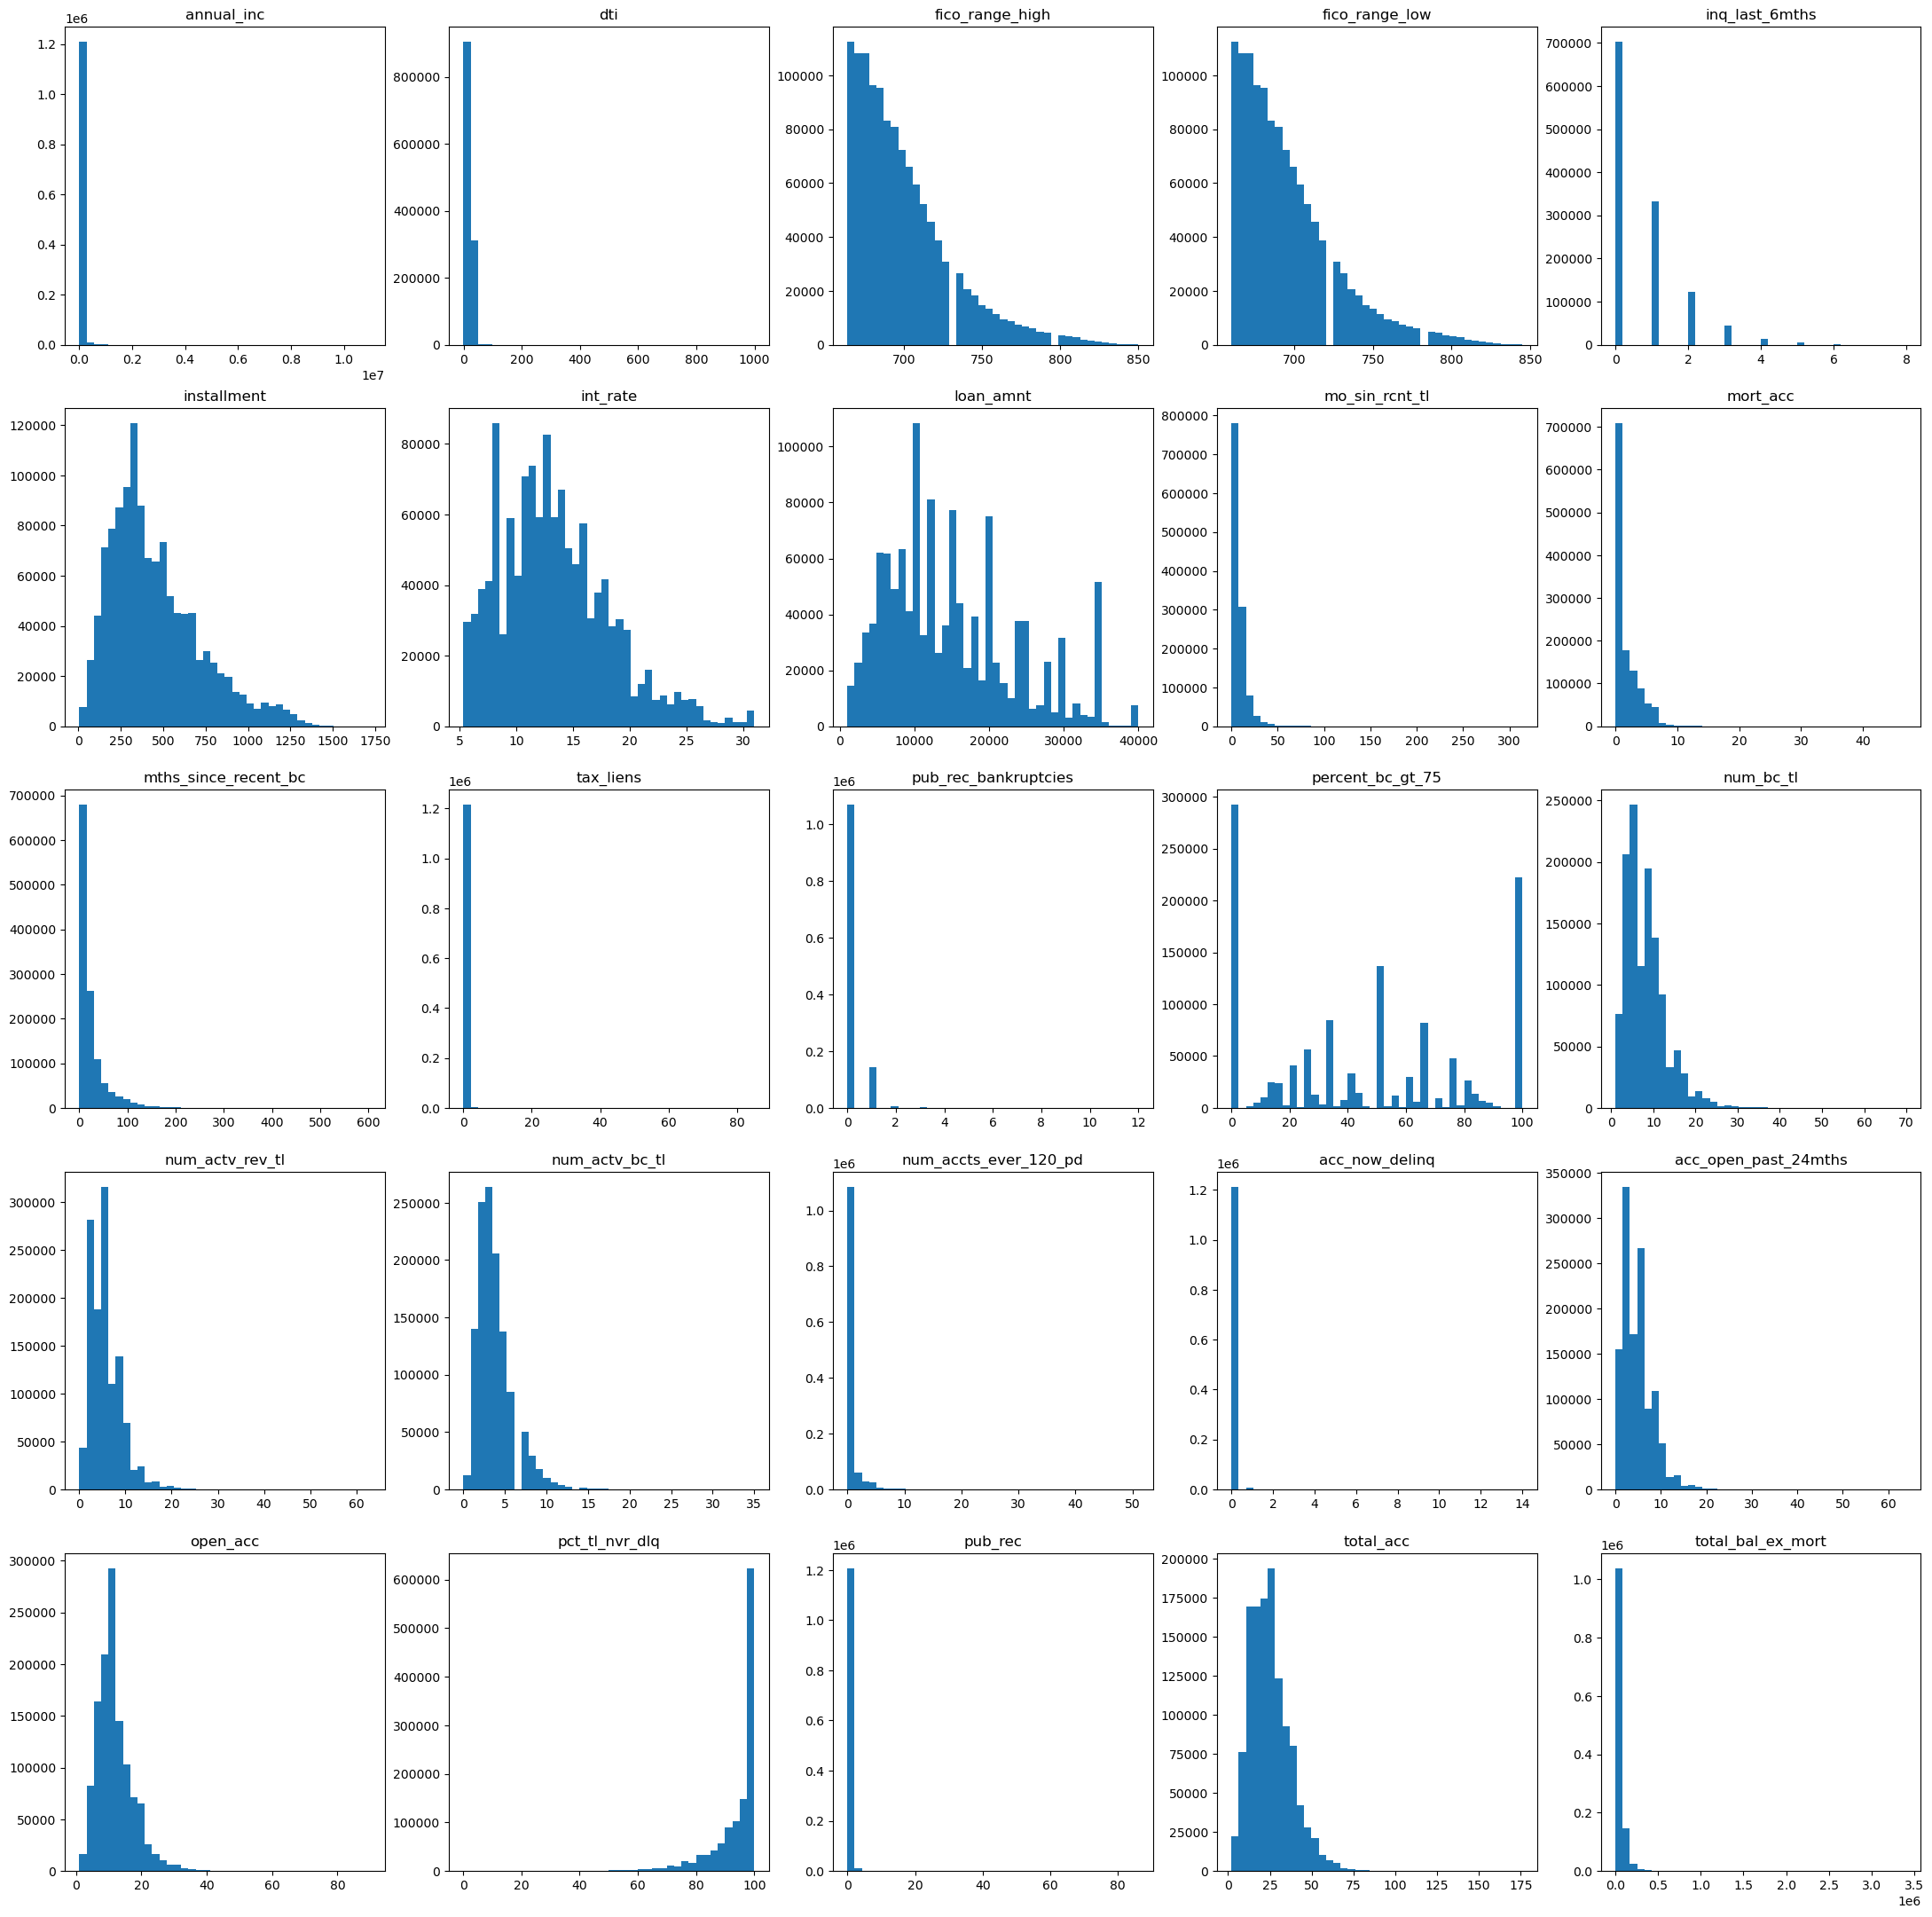

In [11]:
fig, ax = plt.subplots(nrows= 5, ncols= 5, figsize = (27,27))
ax = ax.flatten()
for i,var in enumerate(numeric_vars):
    ax[i].hist(df[var], bins = 40)
    ax[i].set_title(var)
plt.savefig("graphs/num_variables_hists.svg",facecolor = (1,1,1,0), transparent = True)
plt.show()


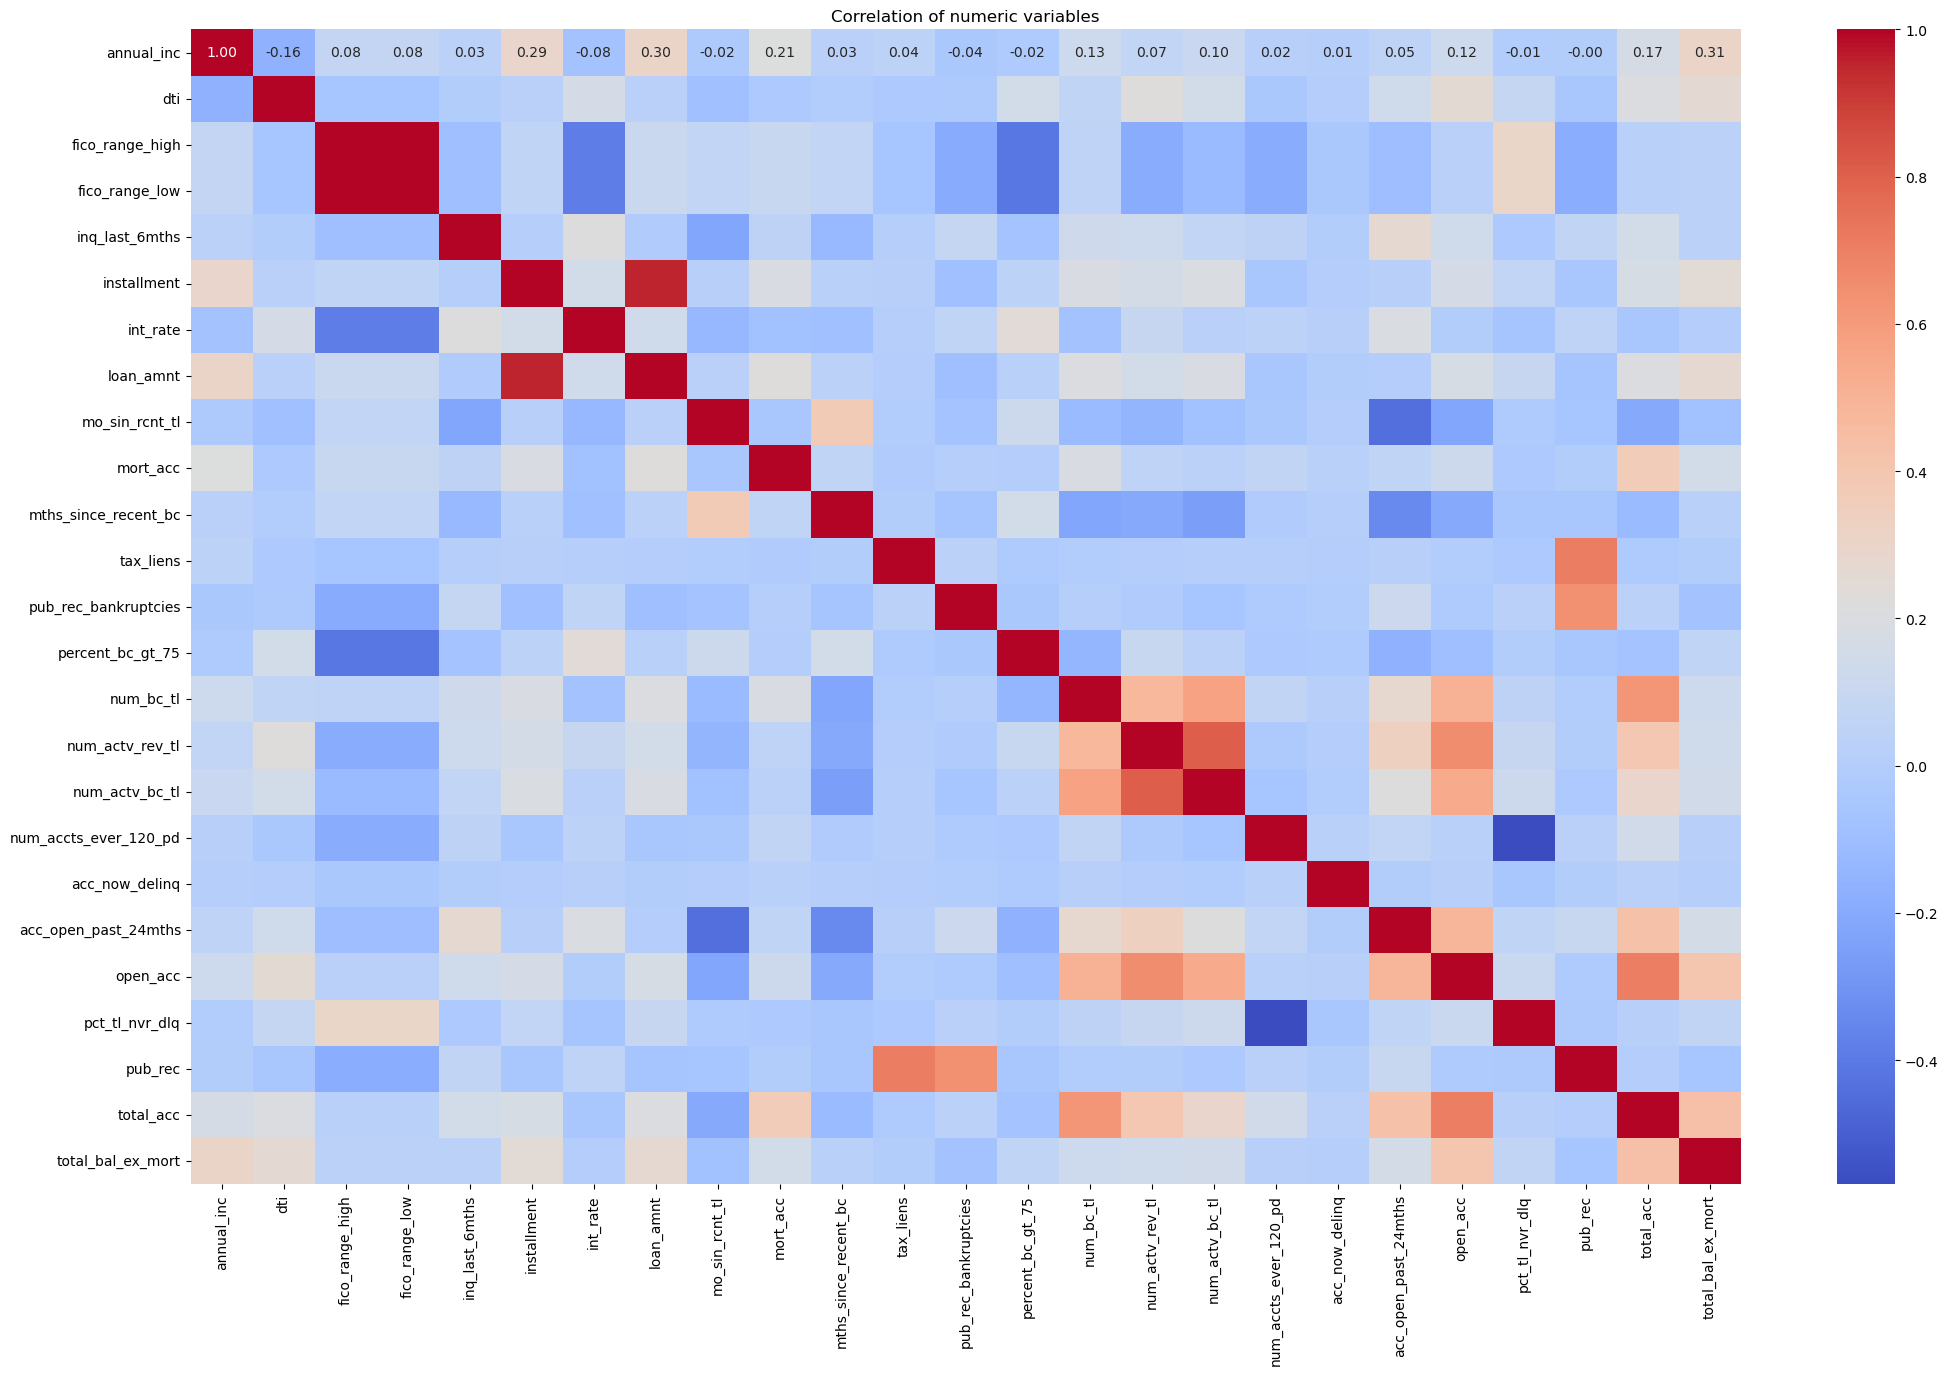

In [12]:
correlation_matrix = df[numeric_vars].corr()
plt.figure(figsize=(25,15))
sns.heatmap(correlation_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation of numeric variables")
plt.show()

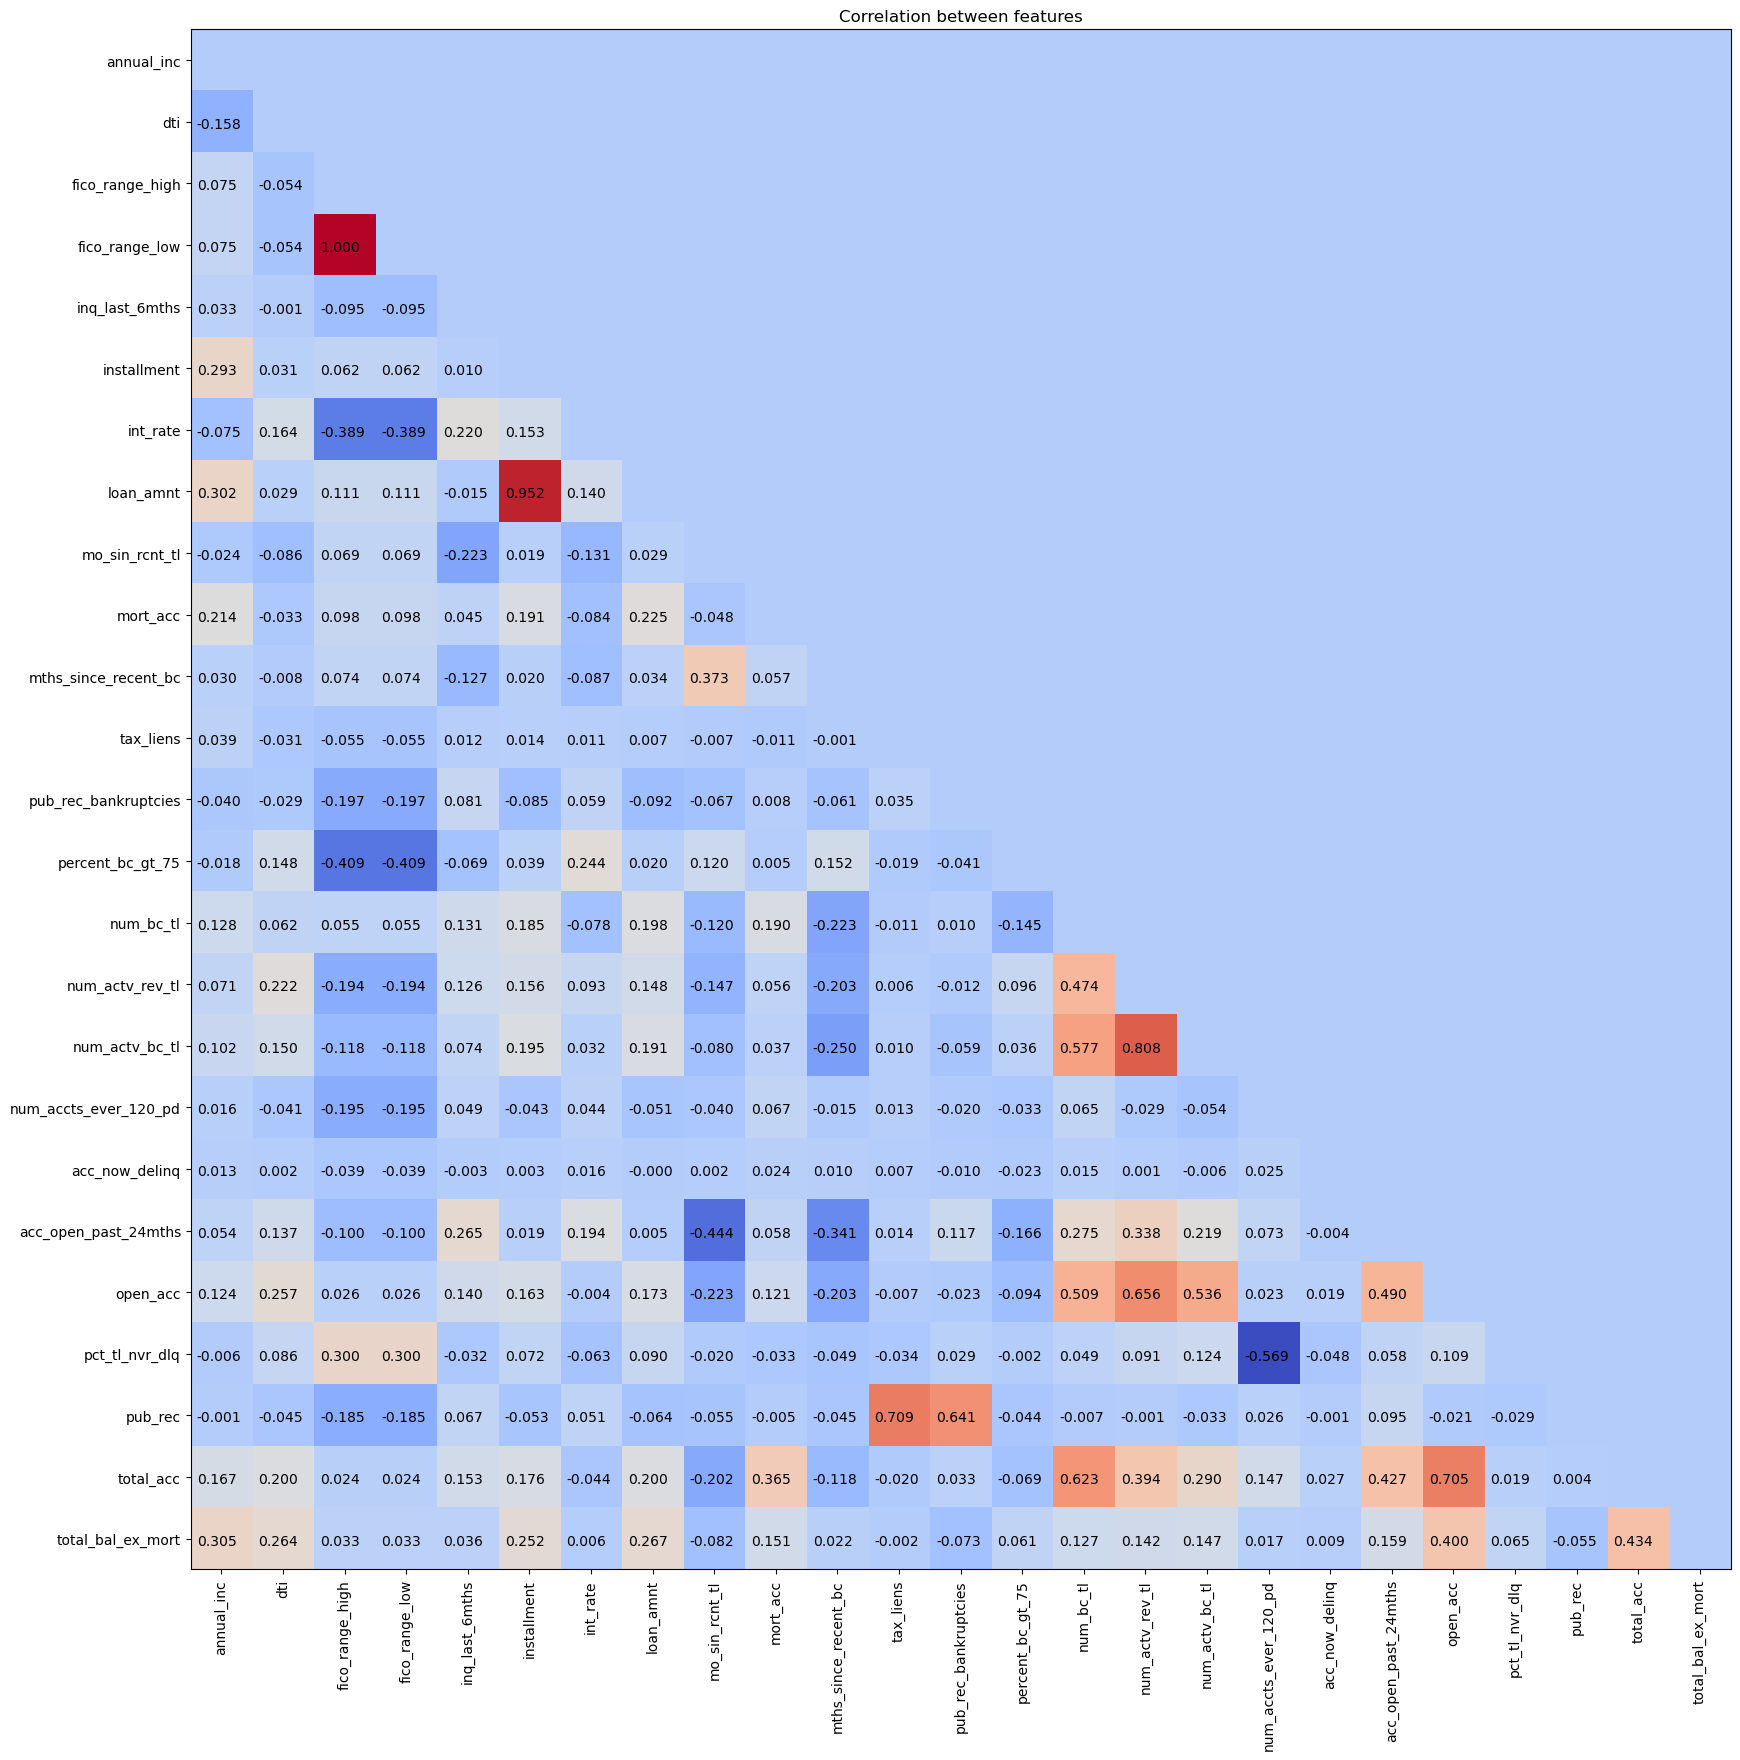

In [13]:
correlation_matrix = df[numeric_vars].corr()
correlation_matrix = correlation_matrix* np.tri(correlation_matrix.shape[0],k=-1)
plt.figure(figsize=(20, 20))
plt.imshow(correlation_matrix,cmap = "coolwarm")
plt.xticks(range(correlation_matrix.shape[0]), correlation_matrix, rotation = 90)
plt.yticks(range(correlation_matrix.shape[0]), correlation_matrix)
for i in range(correlation_matrix.shape[0]):
    for j in range(i):
        plt.text(j-0.4,i+0.1,"{:.3f}".format(correlation_matrix.iloc[i,j]),size = 10)
plt.title("Correlation between features")
# plt.savefig("graphs/features_corr.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

We can see that there are some variables that are highly correlated and just provide the same information: FICO range high and FICO range low; loan amount and installment. Regularization techinques will help dealing with this problem

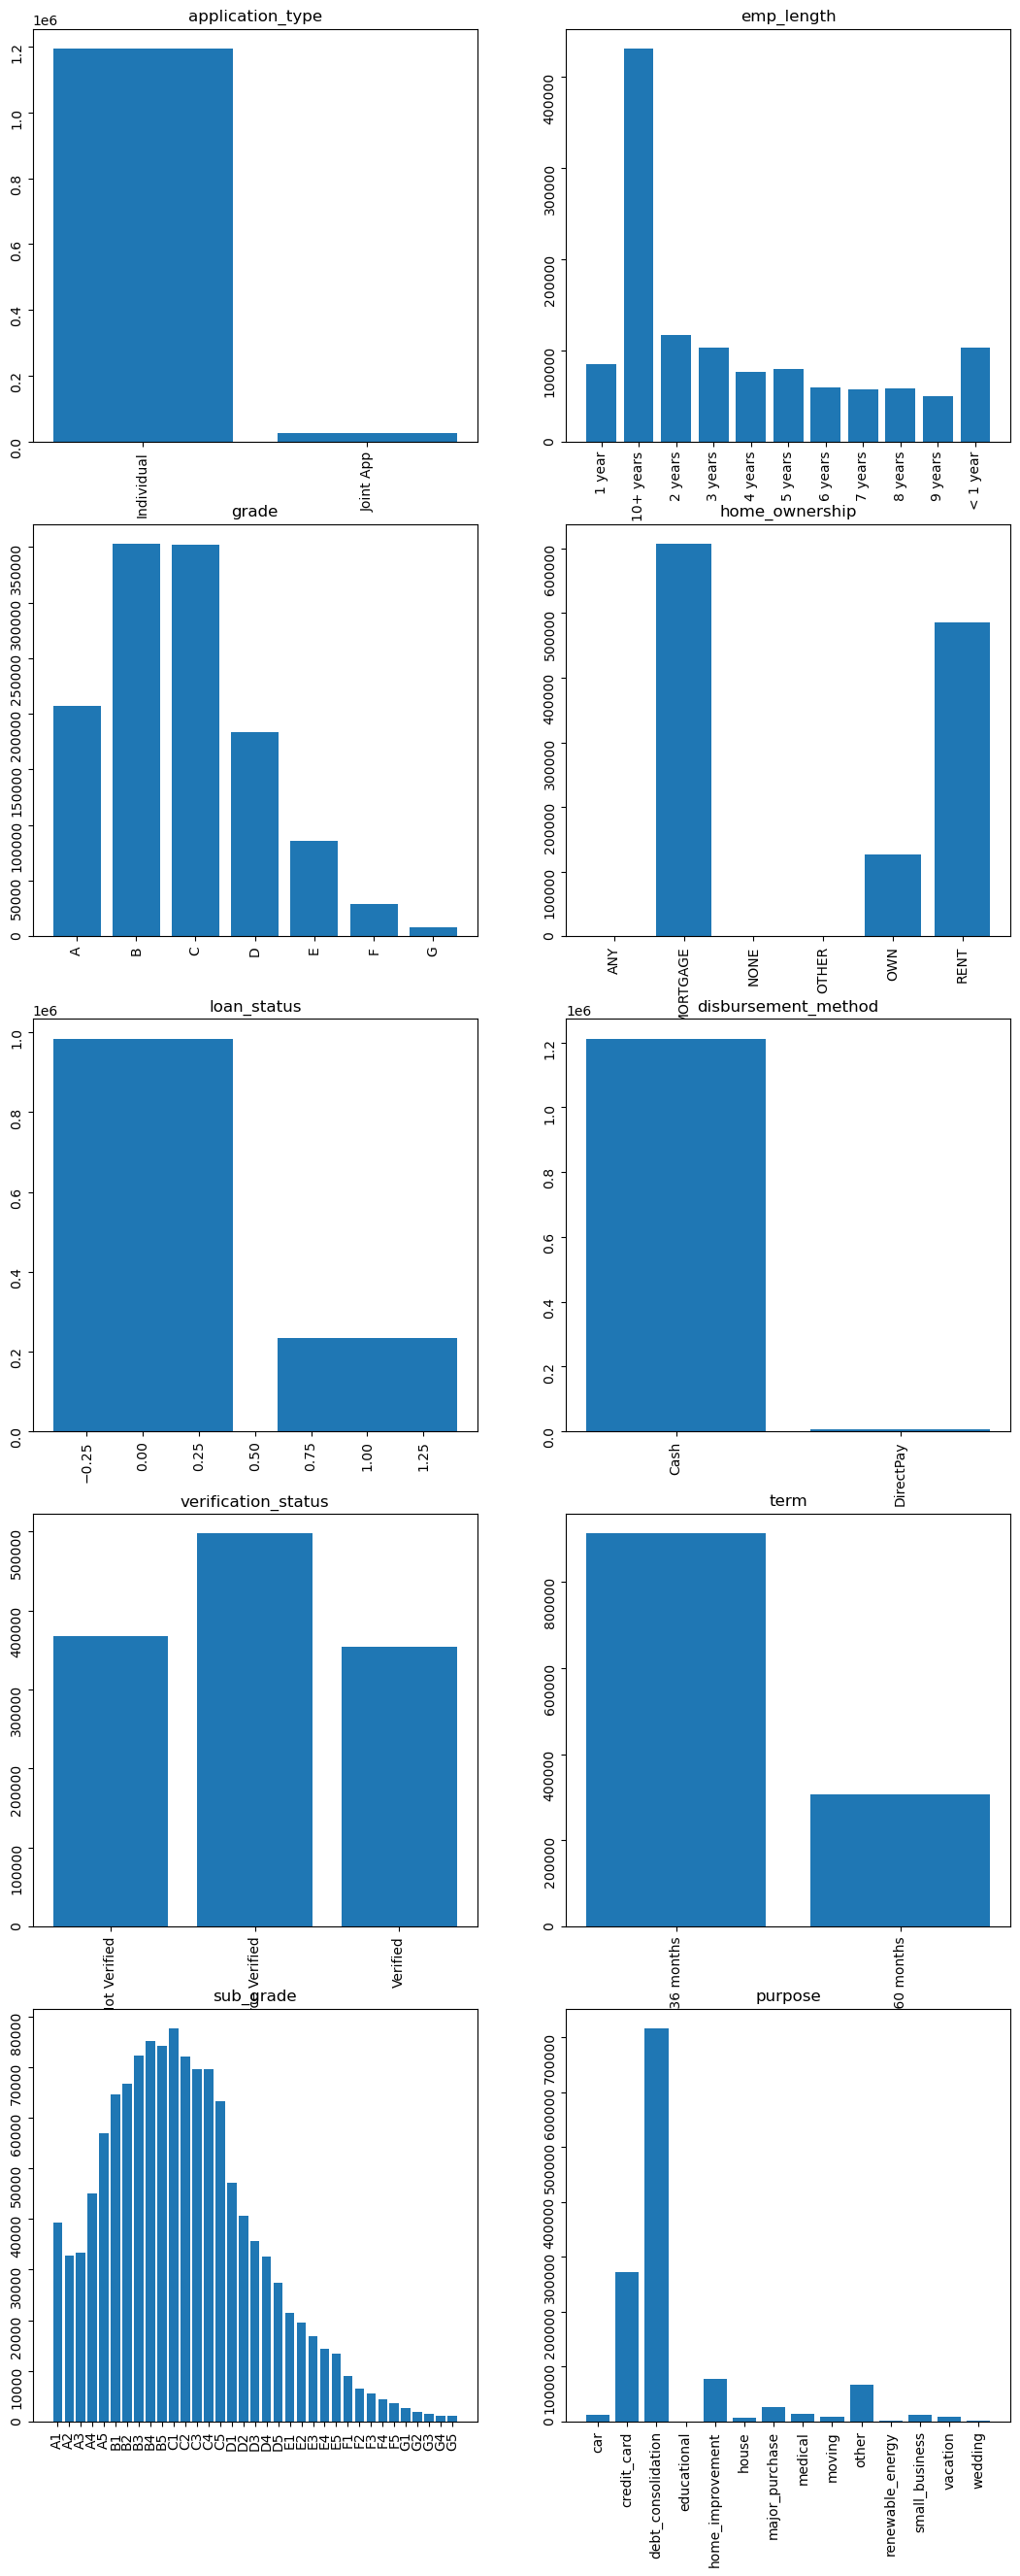

In [14]:
categorical_vars = df.columns[df.dtypes != "float64"]

fig, ax = plt.subplots(nrows= 5, ncols= 2, figsize = (13,32))
ax = ax.flatten()

i=0
for var in categorical_vars:
    if var not in ["earliest_cr_line", "issue_d"]:
        data = df[var].groupby(df[var]).count()
        ax[i].bar(x = data.index, height= data.to_numpy())
        ax[i].set_title(var)
        ax[i].tick_params(labelrotation = 90)
        i += 1 
plt.savefig("graphs/cat_vars_plots.svg",facecolor = (1,1,1,0), transparent = True)
plt.show()

Again we see that some features contain the same information: Grade and Subgrade.

## Encoding categorical Variables

We will need to transform the categorical variables to numeric ones.


In [15]:
from sklearn.preprocessing import OrdinalEncoder

term_dummies = pd.get_dummies(df.term,prefix= "term")
df = pd.concat([df, term_dummies], axis = 1)
df.drop(columns = ["term",'term_ 36 months'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop 36 months since it is the highest frequency class

#subgrade
enc = OrdinalEncoder()
sub_grade_encoded = pd.Series(enc.fit_transform(df.sub_grade.array.reshape(-1,1)).flatten())
sub_grade_encoded = sub_grade_encoded*-1 # we invert the rating: highest grade has the highest number
df.sub_grade = sub_grade_encoded

#grade
enc = OrdinalEncoder()
grade_encoded = pd.Series(enc.fit_transform(df.grade.array.reshape(-1,1)).flatten())
grade_encoded = grade_encoded*-1 # we invert the rating: highest grade has the highest number
df.grade = grade_encoded

#home ownership
# we will first collapse some classes into one: any, none and other will be grouped together
df.home_ownership[df.home_ownership == "ANY"] = "OTHER"
df.home_ownership[df.home_ownership == "NONE"] = "OTHER"

home_ownership_dummies = pd.get_dummies(df.home_ownership,prefix= "home_ownership")
df = pd.concat([df, home_ownership_dummies], axis = 1)
df.drop(columns = ["home_ownership",'home_ownership_MORTGAGE'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop MORTGAGE since it is the highest frequency class

# verification status
verification_status_dummies = pd.get_dummies(df.verification_status,prefix= "verification_status")
df = pd.concat([df, verification_status_dummies], axis = 1)
df.drop(columns = ["verification_status",'verification_status_Source Verified'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop Source Verified since it is the highest frequency class

#purpose
# first we group educational with other because there is only one instance of it
df.purpose[df.purpose == "educational"] = "other"
purpose_dummies = pd.get_dummies(df.purpose,prefix= "purpose")
df = pd.concat([df, purpose_dummies], axis = 1)
df.drop(columns = ["purpose",'purpose_debt_consolidation'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop educational because there is only one value

#application_type
application_type_dummies = pd.get_dummies(df.application_type,prefix= "application_type")
df = pd.concat([df, application_type_dummies], axis = 1)
df.drop(columns = ["application_type",'application_type_Individual'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop application_type since it is the highest frequency class

# disbursement_method
disbursement_method_dummies = pd.get_dummies(df.disbursement_method,prefix= "disbursement_method")
df = pd.concat([df, disbursement_method_dummies], axis = 1)
df.drop(columns = ["disbursement_method",'disbursement_method_Cash'],inplace = True)
#we need to drop one class to avoid perfect collinearity
# we will drop Cash since it is the highest frequency class

#emp_length
emp_length_map = {
    "1 year": 1,
    "10+ years":10,
    "2 years":2,
    "3 years":3,
    "4 years":4,
    "5 years":5,
    "6 years":6,
    "7 years":7,
    "8 years":8,
    "9 years":9,
    "< 1 year" : 0
}

df.emp_length = df.emp_length.map(emp_length_map)



C:\Users\giuse\AppData\Local\Temp\ipykernel_19412\934061891.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.home_ownership[df.home_ownership == "ANY"] = "OTHER"
C:\Users\giuse\AppData\Local\Temp\ipykernel_19412\934061891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.home_ownership[df.home_ownership == "NONE"] = "OTHER"
C:\Users\giuse\AppData\Local\Temp\ipykernel_19412\934061891.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

We also have the variables Issue date and Earliest credit line that are a timestamp. We will encode it with an integer number, setting 0 for the earliest date and the highest number for the latest date

In [16]:
#earliest_credit_line
enc = OrdinalEncoder()
earliest_cr_line_encoded = pd.Series(enc.fit_transform(pd.to_datetime(df.earliest_cr_line, format = "%b-%Y").array.reshape(-1,1)).flatten())
df.earliest_cr_line = earliest_cr_line_encoded

#issue_date
enc = OrdinalEncoder()
issue_d_encoded = pd.Series(enc.fit_transform(pd.to_datetime(df.issue_d, format = "%b-%Y").array.reshape(-1,1)).flatten())
df.issue_d = issue_d_encoded

In [17]:
df.isna().sum().sum()

0

We now plot the variables' distributions according to class of target variable.

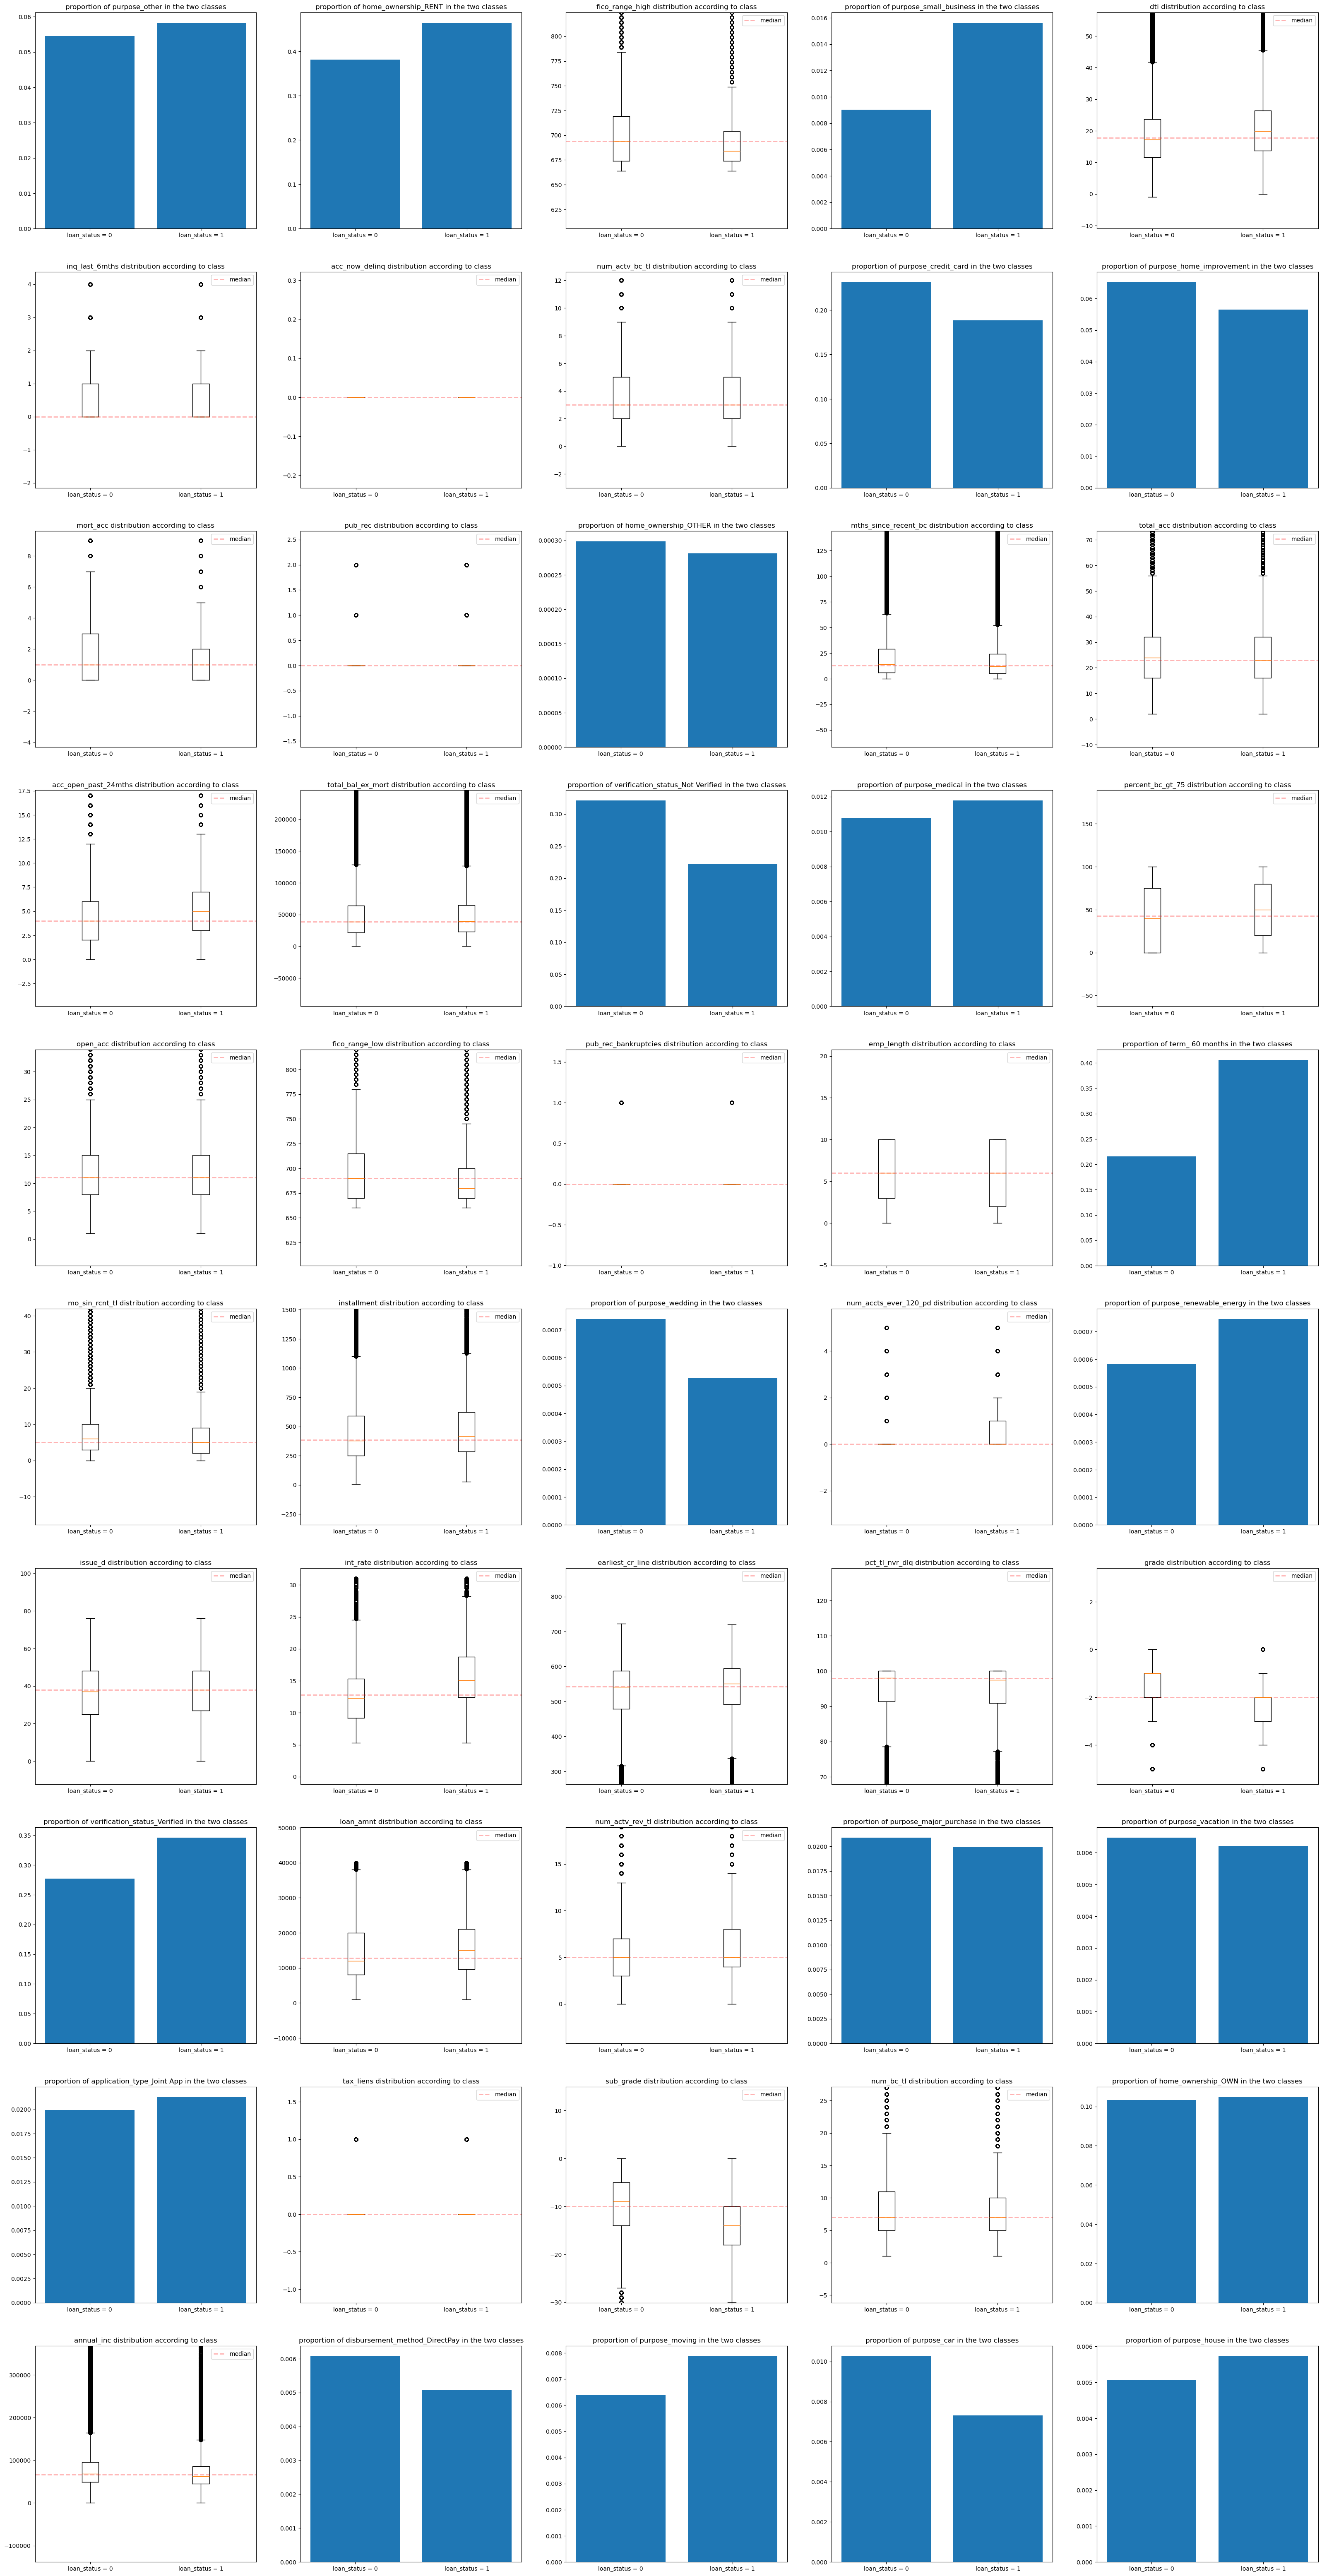

In [18]:
fig, ax = plt.subplots(nrows= 10, ncols= 5, figsize = (40,80))
ax = ax.flatten()

n_loan_status_0 = (df[df.loan_status == 0]).shape[0]
n_loan_status_1 = (df[df.loan_status == 1]).shape[0]
for i,var_name in enumerate(set(df.columns)-set(["loan_status"])):
    if df[var_name].value_counts().size == 2:
        ax[i].bar(x = ("loan_status = 0","loan_status = 1"), height=(df[df.loan_status == 0][var_name].sum()/n_loan_status_0,df[df.loan_status == 1][var_name].sum()/n_loan_status_1))
        ax[i].set_title("proportion of "+var_name +" in the two classes")
    else:
        ax[i].boxplot([df[var_name][df.loan_status == 0],df[var_name][df.loan_status == 1]])
        ax[i].axhline(y=df[var_name].median(), color='r', alpha =0.3, linestyle='--', linewidth=2,label="median")
        ax[i].set_ylim((df[var_name].mean() - 3*df[var_name].std(), df[var_name].mean() + 4*df[var_name].std()))
        ax[i].set_title(var_name + " distribution according to class")
        ax[i].set_xticklabels(("loan_status = 0","loan_status = 1"))
        ax[i].legend()


## Splitting into training, validation, testing


The dataset is still large enough, we will split it into 3 sets.

After that, we will undersample the majority class in the Training Set

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["loan_status"]), df.loan_status, test_size=0.3, random_state=0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.4, random_state=0)

# undersampling of majority class in train dataset
status_1_idx = ((y_train[y_train == 1]).index).array
status_0_idx = ((y_train[y_train == 0]).index).array
np.random.seed(0)
sampled_idx = np.random.choice(status_0_idx, size = status_1_idx.size, replace = False)
sampled_idx = np.concatenate((sampled_idx, status_1_idx))
print("number of rows in train set before undersampling",X_train.index.size)
print("number of rows in train set after undersampling",sampled_idx.size)

y_train = y_train.loc[sampled_idx]
X_train = X_train.loc[sampled_idx]

number of rows in train set before undersampling 512137
number of rows in train set after undersampling 197440


We standardize the variables

In [20]:
train_means = X_train.mean()
train_stds = X_train.std()
X_train= (X_train-train_means)/train_stds
X_val = (X_val-train_means)/train_stds
X_test = (X_test-train_means)/train_stds

In [21]:
# X_train.to_csv("C:/Users/giuse/DatiR/lending_club/X_train.csv",index=False)
# y_train.to_csv("C:/Users/giuse/DatiR/lending_club/y_train.csv",index=False)
# X_val.to_csv("C:/Users/giuse/DatiR/lending_club/X_val.csv",index=False)
# y_val.to_csv("C:/Users/giuse/DatiR/lending_club/y_val.csv",index=False)
# X_test.to_csv("C:/Users/giuse/DatiR/lending_club/X_test.csv",index=False)
# y_test.to_csv("C:/Users/giuse/DatiR/lending_club/y_test.csv",index=False)

## Linear models


### Logistic regression with no penalty

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, jaccard_score

In [23]:
logreg_model = LogisticRegression(penalty = None,max_iter=1000)
# we explicitly set the penalty to none so there is no regularization
logreg_model.fit(X_train,y_train)

LogisticRegression(max_iter=1000, penalty=None)

In [86]:
logReg_yhat_val = logreg_model.predict(X_val)
logreg_phat_val = logreg_model.predict_proba(X_val)[:,1]

print("L1 norm of coefficients: ", np.abs(logreg_model.coef_).sum())
print("L2 norm of coefficients: ", (logreg_model.coef_**2).sum())
print("accuracy", accuracy_score(y_val,logReg_yhat_val))
print("jaccard score: ", jaccard_score(y_val,logReg_yhat_val))
print(classification_report(y_val,logReg_yhat_val))
logreg_cm = pd.DataFrame(confusion_matrix(y_val, logReg_yhat_val))
logreg_cm.index.name="actual"
logreg_cm.columns.name="predicted"
print(logreg_cm)

print("Coefficients of unregularized model")
# Coeffs of unregularized model
logreg_coeffs = (pd.Series(logreg_model.coef_[0], index = logreg_model.feature_names_in_)).sort_values()
logreg_coeffs

L1 norm of coefficients:  3.148642485537606
L2 norm of coefficients:  0.8666789120409131
accuracy 0.6564936472324896
jaccard score:  0.2667262712341272
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181483  94320
1           22962  42661
Coefficients of unregularized model


sub_grade                          -0.728776
int_rate                           -0.327940
mort_acc                           -0.097483
annual_inc                         -0.087941
fico_range_low                     -0.079104
fico_range_high                    -0.078461
total_acc                          -0.077559
total_bal_ex_mort                  -0.059559
verification_status_Not Verified   -0.049306
mths_since_recent_bc               -0.046357
disbursement_method_DirectPay      -0.032651
application_type_Joint App         -0.031895
emp_length                         -0.027275
purpose_credit_card                -0.024223
num_bc_tl                          -0.017835
pub_rec_bankruptcies               -0.014494
mo_sin_rcnt_tl                     -0.012449
verification_status_Verified       -0.012124
purpose_car                        -0.010574
purpose_wedding                    -0.009802
pct_tl_nvr_dlq                     -0.005323
earliest_cr_line                   -0.004684
home_owner

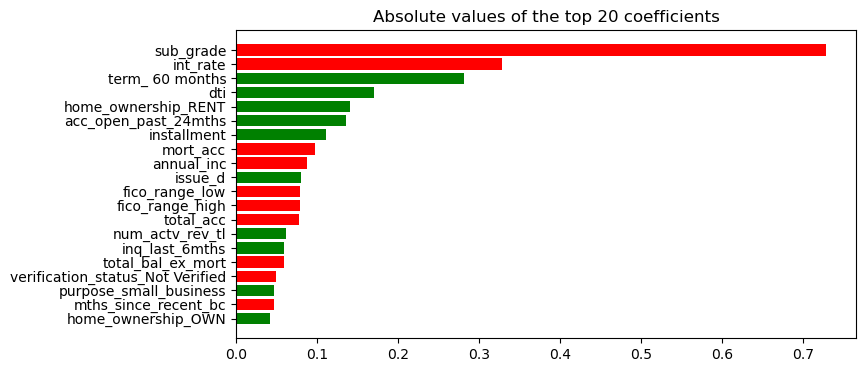

In [25]:
sorted_coeffs = logreg_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/logreg_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

The graph shows the coefficients ranked by absolute values: the highest ones at the top.


Since we standardized all the features they are on the same scale and the coefficients can be compared with one another.


We are only showing the top 20 to make the graph easier to interpret.

Red bars indicate a negative coefficient: the higher the value of the feature, the lower the probability of default.

Green bars are the opposite: the variable has a positive relation with loan default.

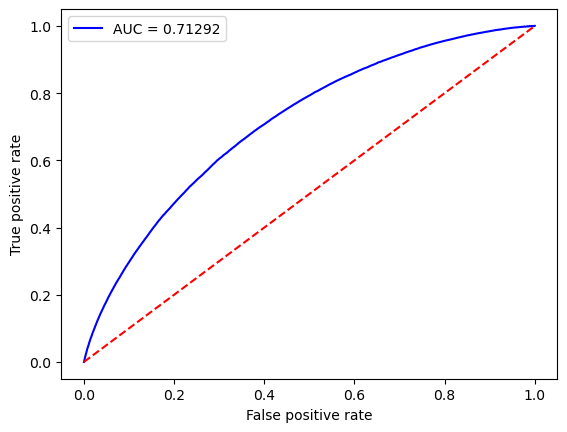

In [26]:
#Roc Curve
logReg_fpr, logReg_tpr, logReg_thresholds = roc_curve(y_val, logreg_phat_val)
logreg_auc_val = roc_auc_score(y_val, logreg_phat_val)
plt.plot(logReg_fpr,logReg_tpr, "b", label = "AUC = %0.5f"%logreg_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

The logistic regression model without penalization is performing well: $0.713$ AUC on the validation set. This suggests that we might not have an overfitting problem.

However the coefficients show some interesting results. The coefficient of interest rate really stands out: according to this model, loans with higher interest rates have a lower probability of default.

This is probably due to correlation with other variables. L1 and L2 regularization will help us understand better what the real relation is.

Beside interest rate, all other coefficients are as expected. The most important one is the sub_grade variable, which is assigned by Lending Club: it summarizes a lot of information on the borrower into a single parameter.

Installment, term, debt to income ratio have positive relation with default as we expected.

Income and FICO score are also how we expected: negatively associated with default.

### LASSO

Lasso, or L1 penalization will shrink some coefficients to 0, effectively performing feature selection.

In [27]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.
# c_values = np.exp(np.arange(10,-1,-0.25))**-1

#parameter cv= number of folds to use in cross validation

lassocv_model = LogisticRegressionCV(penalty="l1", solver="saga", Cs = 40, cv = 5, max_iter = 3500, n_jobs = -1,verbose = 0)
lassocv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, max_iter=3500, n_jobs=-1, penalty='l1',
                     solver='saga')

In [87]:
lassocv_yhat_val = lassocv_model.predict(X_val)
lassocv_phat_val = lassocv_model.predict_proba(X_val)[:,1]

print("num of coefs that have been shrunk to 0: ", (lassocv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(lassocv_model.coef_).sum())
print("L2 norm of coefficients: ", (lassocv_model.coef_**2).sum())
print("accuracy", accuracy_score(y_val,lassocv_yhat_val))
print("jaccard score: ", jaccard_score(y_val,lassocv_yhat_val))
print(classification_report(y_val,lassocv_yhat_val))
lassocv_cm = pd.DataFrame(confusion_matrix(y_val, lassocv_yhat_val))
lassocv_cm.index.name="actual"
lassocv_cm.columns.name="predicted"
print(lassocv_cm)
print("Coefficients of LASSO model")
lassocv_coeffs=(pd.Series(lassocv_model.coef_[0], index = lassocv_model.feature_names_in_)).sort_values()
lassocv_coeffs

num of coefs that have been shrunk to 0:  2
L1 norm of coefficients:  2.9978289625257446
L2 norm of coefficients:  0.768026081029279
accuracy 0.6566020162494948
jaccard score:  0.26662288109088633
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181556  94247
1           22998  42625
Coefficients of LASSO model


sub_grade                          -0.684846
int_rate                           -0.287759
mort_acc                           -0.097702
annual_inc                         -0.084779
fico_range_low                     -0.080569
fico_range_high                    -0.076761
total_acc                          -0.075617
total_bal_ex_mort                  -0.058163
verification_status_Not Verified   -0.048976
mths_since_recent_bc               -0.045691
disbursement_method_DirectPay      -0.031939
application_type_Joint App         -0.031315
emp_length                         -0.026280
purpose_credit_card                -0.023823
num_bc_tl                          -0.016184
mo_sin_rcnt_tl                     -0.011986
verification_status_Verified       -0.011133
purpose_car                        -0.010003
pub_rec_bankruptcies               -0.009922
purpose_wedding                    -0.009212
pct_tl_nvr_dlq                     -0.004989
earliest_cr_line                   -0.002870
home_owner

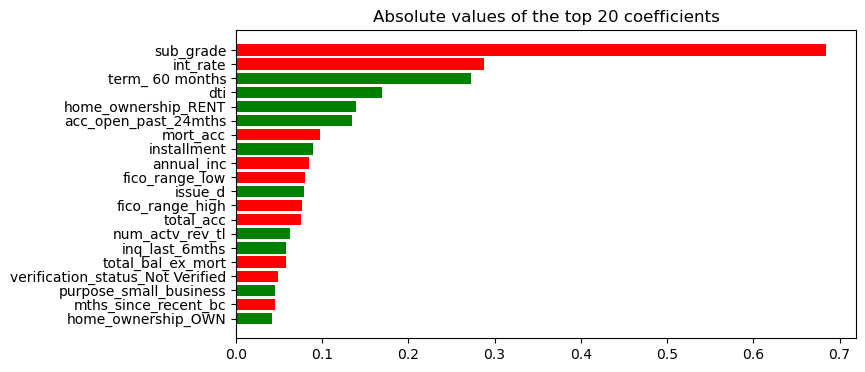

In [29]:

sorted_coeffs = lassocv_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/lassocv_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

34.551072945922186 	 this is the optimal lambda parameter


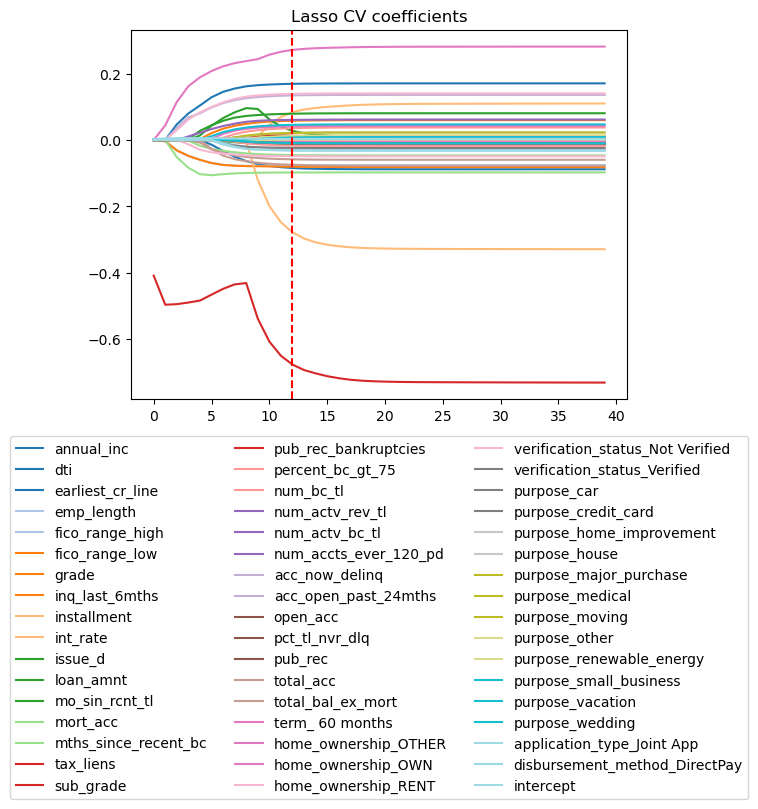

In [30]:
print((lassocv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(lassocv_model.feature_names_in_)
pd.DataFrame(lassocv_model.coefs_paths_[1].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(lassocv_model.Cs_ == lassocv_model.C_),linestyle="--",color="red")
# plt.xticks(range(1,41),labels = lassocv_model.Cs_,size = 5)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.title("Lasso CV coefficients")
plt.show()

The regularization strength chosen by cross validation is not really high: the model still looks a lot like the previous one. The L1 norm of the coefficients only dropped by $0.14$. Only two coefficients were shrunk to 0, and all the others look the same as the previous model.

The red vertical line in the graph above shows the chosen level: we can see that the coefficients start to shrink toward 0 with levels of regularization that are higher than the value resulting by Cross Validation.

As we suspected, the model without penalization did not have problems with overfitting. Some regularization is however performed, but we can see from the graph below that there is no improvement in AUC.

 

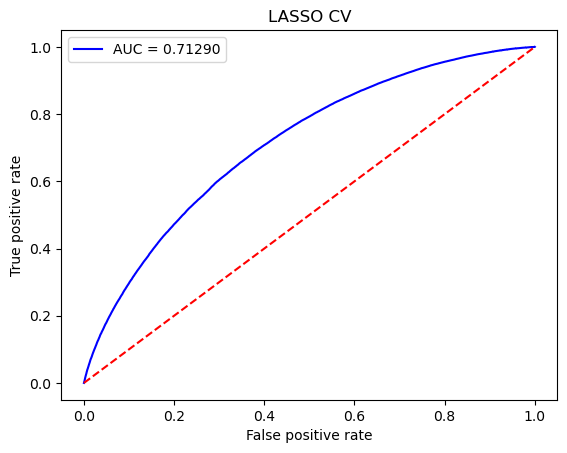

In [31]:
lassocv_fpr, lassocv_tpr, lassocv_thresholds = roc_curve(y_val, lassocv_phat_val)
lassocv_auc_val = roc_auc_score(y_val, lassocv_phat_val)
plt.plot(lassocv_fpr,lassocv_tpr, "b", label = "AUC = %0.5f"%lassocv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("LASSO CV")
plt.show()

### Ridge

In [32]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.

#parameter cv= number of folds to use in cross validation

ridgecv_model = LogisticRegressionCV(penalty="l2", solver="saga", Cs = 40, cv = 5, max_iter = 3500, n_jobs = -1,verbose = 0)
ridgecv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, max_iter=3500, n_jobs=-1, solver='saga')

In [88]:
ridgecv_yhat_val = ridgecv_model.predict(X_val)
ridgecv_phat_val = ridgecv_model.predict_proba(X_val)[:,1]

print("num of coefs that have been shrunk to 0: ", (ridgecv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(ridgecv_model.coef_).sum())
print("L2 norm of coefficients: ", (ridgecv_model.coef_**2).sum())
print("accuracy: ", accuracy_score(y_val,ridgecv_yhat_val))
print("jaccard score: ", jaccard_score(y_val,ridgecv_yhat_val))
print(classification_report(y_val,ridgecv_yhat_val))
ridgecv_cm = pd.DataFrame(confusion_matrix(y_val, ridgecv_yhat_val))
ridgecv_cm.index.name="actual"
ridgecv_cm.columns.name="predicted"
print(ridgecv_cm)
print("Coefficients of Ridge")
ridgecv_coeffs = (pd.Series(ridgecv_model.coef_[0], index = ridgecv_model.feature_names_in_)).sort_values()
ridgecv_coeffs


num of coefs that have been shrunk to 0:  0
L1 norm of coefficients:  3.1386412734006153
L2 norm of coefficients:  0.856886805816132
accuracy:  0.6564877894477866
jaccard score:  0.2667366894240628
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181478  94325
1           22959  42664
Coefficients of Ridge


sub_grade                          -0.723907
int_rate                           -0.324874
mort_acc                           -0.097528
annual_inc                         -0.088041
fico_range_low                     -0.079923
fico_range_high                    -0.077700
total_acc                          -0.077520
total_bal_ex_mort                  -0.059538
verification_status_Not Verified   -0.049347
mths_since_recent_bc               -0.046379
disbursement_method_DirectPay      -0.032658
application_type_Joint App         -0.031936
emp_length                         -0.027274
purpose_credit_card                -0.024248
num_bc_tl                          -0.017890
pub_rec_bankruptcies               -0.014540
mo_sin_rcnt_tl                     -0.012447
verification_status_Verified       -0.012140
purpose_car                        -0.010575
purpose_wedding                    -0.009807
pct_tl_nvr_dlq                     -0.005338
earliest_cr_line                   -0.004667
home_owner

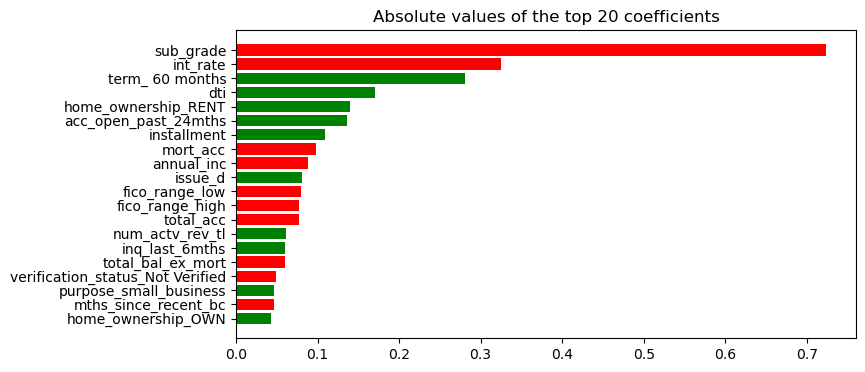

In [34]:
sorted_coeffs = ridgecv_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/ridgecv_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

5.2233450742668435 	 this is the optimal lambda parameter


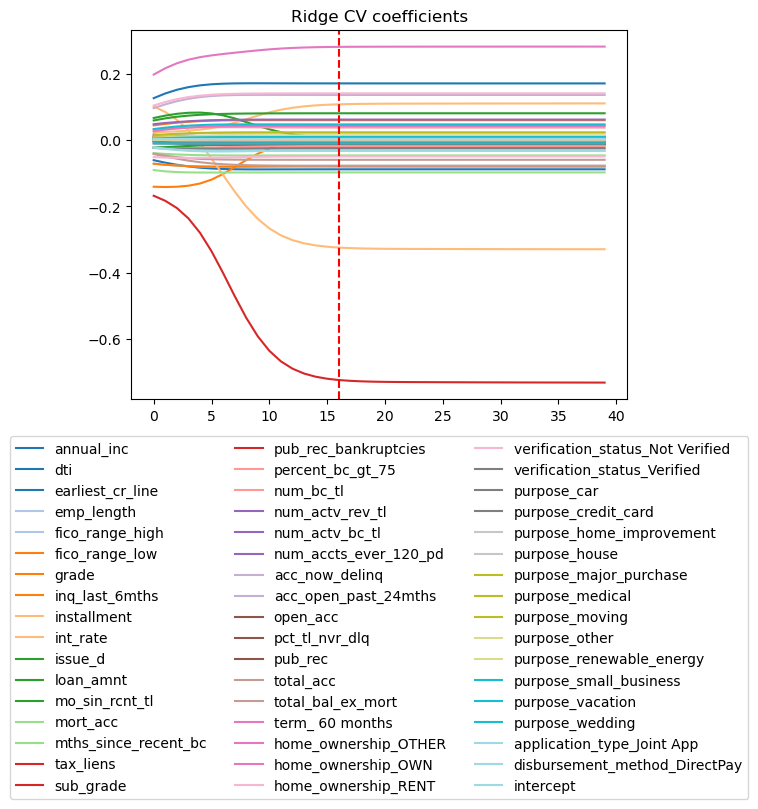

In [35]:
print((ridgecv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(ridgecv_model.feature_names_in_)
pd.DataFrame(ridgecv_model.coefs_paths_[1].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(ridgecv_model.Cs_ == ridgecv_model.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.title("Ridge CV coefficients")
plt.show()

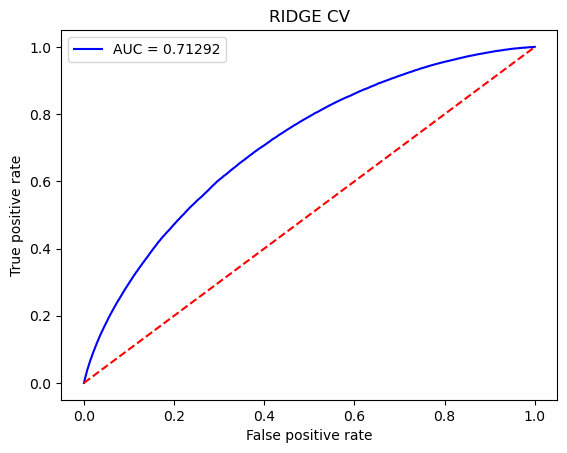

In [36]:
ridgecv_fpr, ridgecv_tpr, ridgecv_thresholds = roc_curve(y_val, ridgecv_phat_val)
ridgecv_auc_val = roc_auc_score(y_val, ridgecv_phat_val)
plt.plot(ridgecv_fpr,ridgecv_tpr, "b", label = "AUC = %0.5f"%ridgecv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("RIDGE CV")
plt.show()

As was the case with L1 regularization, the cross validation selected a low penalty parameter and the model is very similar to the previous ones.

### Elastic net

We will fit an elastic net with $0.5$ as L1 ratio: the penalty is the average between L1 and L2 norm

In [37]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.

#parameter cv= number of folds to use in cross validation

elasticnetcv_model = LogisticRegressionCV(penalty="elasticnet", solver="saga", Cs = 40, cv = 5, 
                                          l1_ratios= [0.5], max_iter = 3500, n_jobs = -1,verbose = 0)
elasticnetcv_model.fit(X_train,y_train)

LogisticRegressionCV(Cs=40, cv=5, l1_ratios=[0.5], max_iter=3500, n_jobs=-1,
                     penalty='elasticnet', solver='saga')

In [89]:
elasticnetcv_yhat_val = elasticnetcv_model.predict(X_val)
elasticnetcv_phat_val = elasticnetcv_model.predict_proba(X_val)[:,1]
print("num of coefs that have been shrunk to 0: ", (elasticnetcv_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(elasticnetcv_model.coef_).sum())
print("L2 norm of coefficients: ", (elasticnetcv_model.coef_**2).sum())
print("accuracy: ", accuracy_score(y_val,elasticnetcv_yhat_val))
print("jaccard score: ", jaccard_score(y_val,elasticnetcv_yhat_val))
print(classification_report(y_val,elasticnetcv_yhat_val))
elasticnetcv_cm = pd.DataFrame(confusion_matrix(y_val, elasticnetcv_yhat_val))
elasticnetcv_cm.index.name="actual"
elasticnetcv_cm.columns.name="predicted"
print(elasticnetcv_cm)
print("coefficients of Elastic net")
elasticnetcv_coeffs = (pd.Series(elasticnetcv_model.coef_[0], index = elasticnetcv_model.feature_names_in_)).sort_values()
elasticnetcv_coeffs

num of coefs that have been shrunk to 0:  2
L1 norm of coefficients:  2.9923646397177275
L2 norm of coefficients:  0.7517134391788577
accuracy:  0.6566518074194702
jaccard score:  0.26671087035392144
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    275803
           1       0.31      0.65      0.42     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.78      0.66      0.69    341426

predicted       0      1
actual                  
0          181560  94243
1           22985  42638
coefficients of Elastic net


sub_grade                          -0.676126
int_rate                           -0.279662
mort_acc                           -0.097717
annual_inc                         -0.085501
fico_range_low                     -0.079666
fico_range_high                    -0.077992
total_acc                          -0.075675
total_bal_ex_mort                  -0.058396
verification_status_Not Verified   -0.049241
mths_since_recent_bc               -0.045849
disbursement_method_DirectPay      -0.032120
application_type_Joint App         -0.031679
emp_length                         -0.026471
purpose_credit_card                -0.024022
num_bc_tl                          -0.016756
mo_sin_rcnt_tl                     -0.012191
verification_status_Verified       -0.011518
pub_rec_bankruptcies               -0.010907
purpose_car                        -0.010120
purpose_wedding                    -0.009358
pct_tl_nvr_dlq                     -0.005110
earliest_cr_line                   -0.003163
home_owner

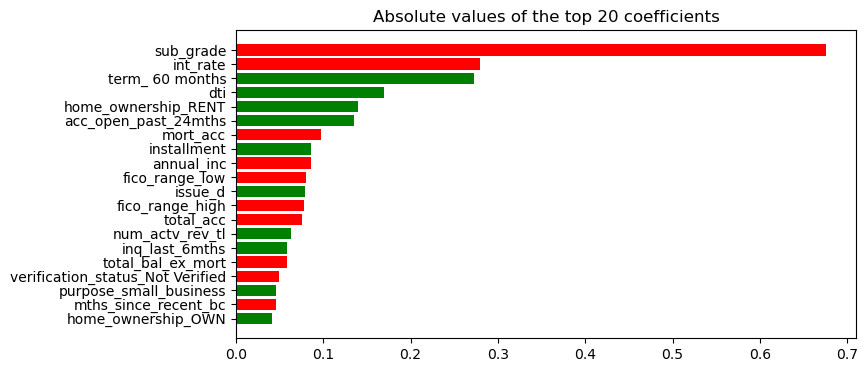

In [39]:
sorted_coeffs = elasticnetcv_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs.iloc[-20:]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of the top 20 coefficients")
plt.savefig("graphs/elasticnetcv_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

55.41020330009492 	 this is the optimal lambda parameter


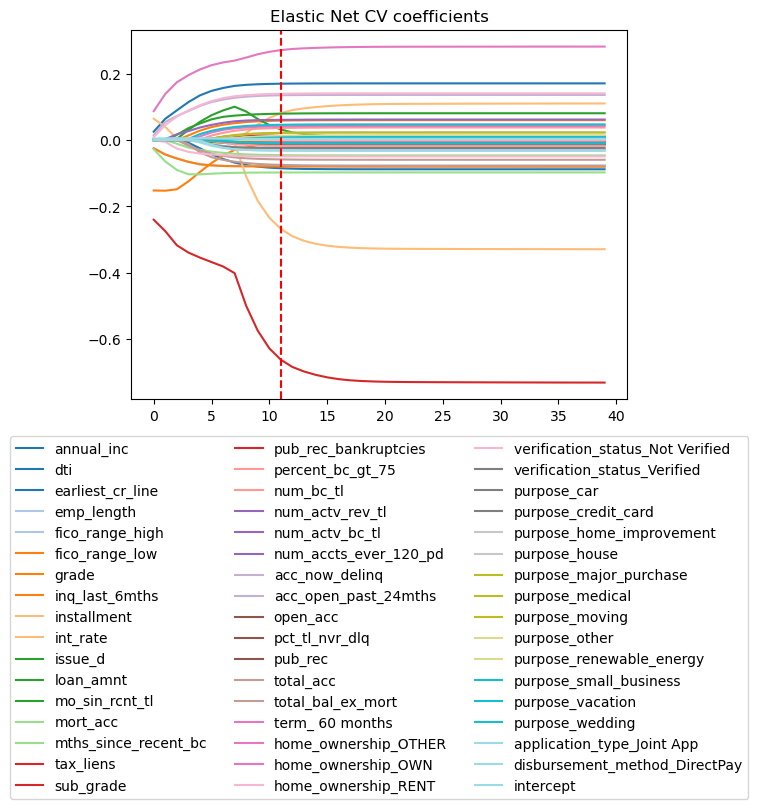

In [40]:
print((elasticnetcv_model.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(elasticnetcv_model.feature_names_in_)
pd.DataFrame(elasticnetcv_model.coefs_paths_[1][:,:,0,:].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(elasticnetcv_model.Cs_ == elasticnetcv_model.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.1),ncols=3)
plt.title("Elastic Net CV coefficients")
plt.show()

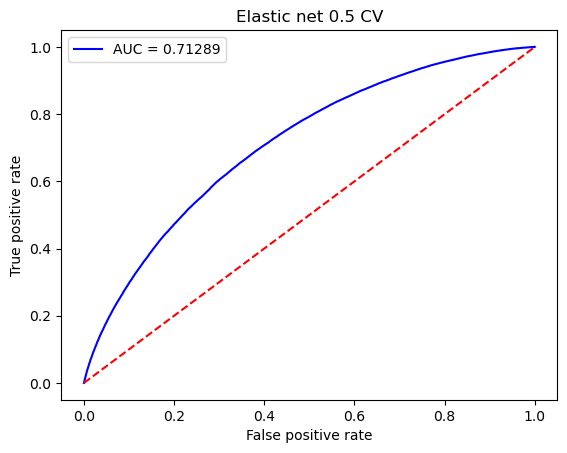

In [41]:
elasticnetcv_fpr, elasticnetcv_tpr, elasticnetcv_thresholds = roc_curve(y_val, elasticnetcv_phat_val)
elasticnetcv_auc_val = roc_auc_score(y_val, elasticnetcv_phat_val)
plt.plot(elasticnetcv_fpr,elasticnetcv_tpr, "b", label = "AUC = %0.5f"%elasticnetcv_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net 0.5 CV")
plt.show()

Again, not much different in this model: cross validation selects values that shrink the coefficients only by small amounts.

We can see that the coefficient that dropped to 0 first is grade: it contains the same information as sub_grade but in less detail. The fact that this happened tells us that regularization can help us select the most important features. We need to select a stronger regularization parameter even if it means a slighlty worse overall performance.

### Elastic net with a high penalty

We want to chose a high regularization parameter to force the model to pick only a few features

In [42]:
print(np.argmax(elasticnetcv_model.C_ == elasticnetcv_model.Cs_),"is the index of the regularization parameter of the previous model")
elasticnetcv_model.Cs_[:13]

11 is the index of the regularization parameter of the previous model


array([0.0001    , 0.00016037, 0.00025719, 0.00041246, 0.00066147,
       0.00106082, 0.00170125, 0.00272833, 0.00437548, 0.00701704,
       0.01125336, 0.01804722, 0.02894266])

The C parameter in the function sklearn.linear_model.LogisticRegression is the inverse of regularization strenght.

Low numbers mean strong regularization.

We will pick a value that is between the third and fourth lowest values searched by cross validation. The one that was selected by the previous model was the eleventh lowest.

In [43]:
from sklearn.linear_model import LogisticRegression
en_highreg_model = LogisticRegression(penalty = "elasticnet", l1_ratio = 0.9, C = 0.00035,
                                  max_iter=3500, solver = "saga", n_jobs=-1)

en_highreg_model.fit(X_train,y_train)

LogisticRegression(C=0.00035, l1_ratio=0.9, max_iter=3500, n_jobs=-1,
                   penalty='elasticnet', solver='saga')

In [90]:
en_highreg_yhat_val = en_highreg_model.predict(X_val)
en_highreg_phat_val = en_highreg_model.predict_proba(X_val)[:,1]
print("num of coefs that have been shrunk to 0: ", (en_highreg_model.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(en_highreg_model.coef_).sum())
print("L2 norm of coefficients: ", (en_highreg_model.coef_**2).sum())
print("accuracy: ", accuracy_score(y_val,en_highreg_yhat_val))
print("jaccard score: ", jaccard_score(y_val,en_highreg_yhat_val))
print(classification_report(y_val,en_highreg_yhat_val))
en_highreg_cm = pd.DataFrame(confusion_matrix(y_val, en_highreg_yhat_val))
en_highreg_cm.index.name="actual"
en_highreg_cm.columns.name="predicted"
print(en_highreg_cm)
print("coefficients of Elastic net")
en_highreg_coeffs = (pd.Series(en_highreg_model.coef_[0], index = en_highreg_model.feature_names_in_)).sort_values()
en_highreg_coeffs

num of coefs that have been shrunk to 0:  37
L1 norm of coefficients:  1.1410336912784043
L2 norm of coefficients:  0.2857115027108448
accuracy:  0.6581543291957848
jaccard score:  0.26174602772998684
              precision    recall  f1-score   support

           0       0.88      0.66      0.76    275803
           1       0.31      0.63      0.41     65623

    accuracy                           0.66    341426
   macro avg       0.60      0.65      0.59    341426
weighted avg       0.77      0.66      0.69    341426

predicted       0      1
actual                  
0          183330  92473
1           24242  41381
coefficients of Elastic net


sub_grade                          -0.471943
mort_acc                           -0.090515
fico_range_low                     -0.052721
fico_range_high                    -0.052415
verification_status_Not Verified   -0.020867
grade                              -0.011597
mths_since_recent_bc               -0.007813
annual_inc                          0.000000
total_bal_ex_mort                   0.000000
home_ownership_OTHER                0.000000
home_ownership_OWN                  0.000000
verification_status_Verified        0.000000
purpose_car                         0.000000
purpose_credit_card                 0.000000
purpose_home_improvement            0.000000
purpose_house                       0.000000
purpose_major_purchase              0.000000
purpose_medical                     0.000000
purpose_moving                      0.000000
purpose_other                       0.000000
purpose_renewable_energy            0.000000
purpose_small_business              0.000000
purpose_va

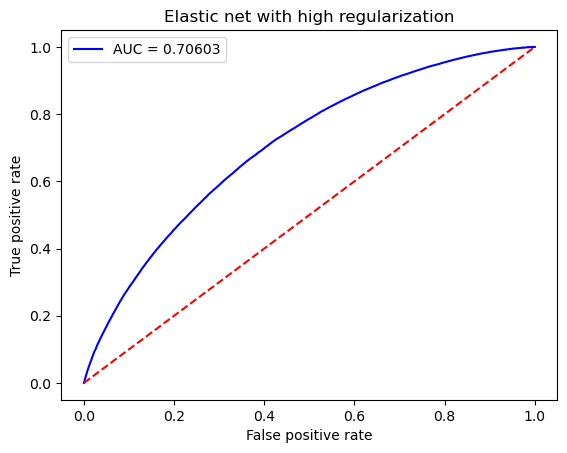

In [91]:
en_highreg_fpr, en_highreg_tpr, en_highreg_thresholds = roc_curve(y_val, en_highreg_phat_val)
en_highreg_auc_val = roc_auc_score(y_val, en_highreg_phat_val)
plt.plot(en_highreg_fpr,en_highreg_tpr, "b", label = "AUC = %0.5f"%en_highreg_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net with high regularization")
plt.show()

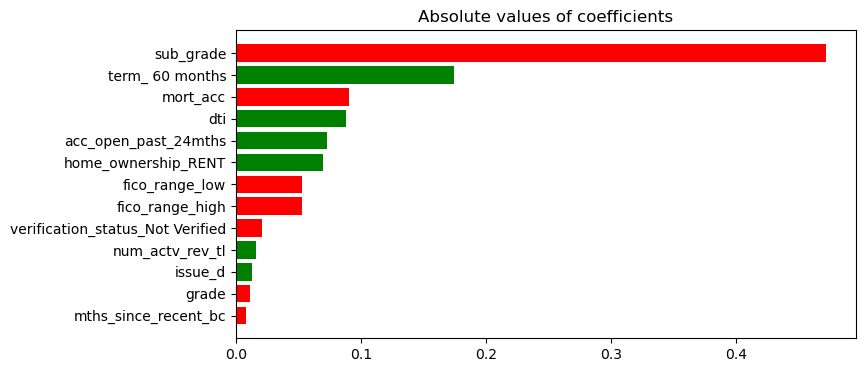

In [46]:
sorted_coeffs = en_highreg_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs[sorted_coeffs.abs_value !=0]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of coefficients")
plt.savefig("graphs/en_highreg_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

This high regularization strenght model shows very interesting results: it drops 37 out of 50 features, only 13 remain.

The AUC performance however is almost unchanged: it barely drops from $0.713$ to $0.706$

The coefficients that are selected however perfectly reflect our expectations: higher interest rates are no longer negatively associated with default. 

Sub grade is still the most important feature.

5 years loans have greater probability of default than 3 year loans.
Borrowers who rent their home have higher probability of default than people who own it or have a mortgage. 

### Correlation between models' coefficients

In [47]:
pd.DataFrame({"log_reg":logreg_coeffs,
              "Lasso_CV":lassocv_coeffs,
              "Ridge_CV":ridgecv_coeffs,
              "ElasticNetCV":elasticnetcv_coeffs,
              "ElasticNet_High":en_highreg_coeffs}).corr()

log_reg  Lasso_CV  Ridge_CV  ElasticNetCV  ElasticNet_High
log_reg          1.000000  0.998967  0.999989      0.998530         0.899663
Lasso_CV         0.998967  1.000000  0.999138      0.999946         0.908107
Ridge_CV         0.999989  0.999138  1.000000      0.998737         0.900004
ElasticNetCV     0.998530  0.999946  0.998737      1.000000         0.909033
ElasticNet_High  0.899663  0.908107  0.900004      0.909033         1.000000

The 5 models we fit so far all have the same performance, and they also have almost perfect correlation between their coefficients. The last model has a slightly lower correlation only because a large majority of its coefficients are 0.

## Tree based models

### Random forest

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

random_forest = RandomForestClassifier(n_estimators=1500, max_features = "sqrt", random_state=0, n_jobs= -1)

random_forest.fit(X_train, y_train)

random_forest_phat_val = random_forest.predict_proba(X_val)[:,1]
random_forest_yhat_val = random_forest.predict(X_val)


In [125]:
print(f"accuracy: {accuracy_score(y_val,random_forest_yhat_val):5f}",
      f"jaccard score: {jaccard_score(y_val, random_forest_yhat_val):5f}",
      classification_report(y_val, random_forest_yhat_val),sep="\n")

random_forest_cm = pd.DataFrame(confusion_matrix(y_val, random_forest_yhat_val))
random_forest_cm.index.name="actual"
random_forest_cm.columns.name="predicted"
print(random_forest_cm)
print("confusion matrix")



accuracy: 0.645865
jaccard score: 0.270891
              precision    recall  f1-score   support

           0       0.89      0.64      0.74    275803
           1       0.31      0.68      0.43     65623

    accuracy                           0.65    341426
   macro avg       0.60      0.66      0.59    341426
weighted avg       0.78      0.65      0.68    341426

predicted       0       1
actual                   
0          175592  100211
1           20700   44923
confusion matrix


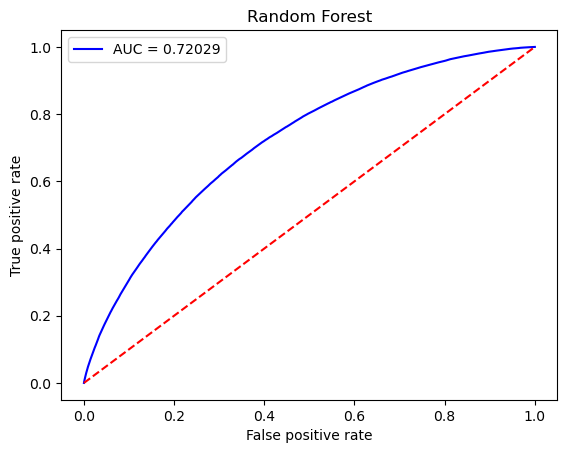

In [126]:
random_forest_fpr, random_forest_tpr, random_forest_thresholds = roc_curve(y_val, random_forest_phat_val)
random_forest_auc_val = roc_auc_score(y_val, random_forest_phat_val)
plt.plot(random_forest_fpr,random_forest_tpr, "b", label = "AUC = %0.5f"%random_forest_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Random Forest")
plt.savefig("graphs/rand_forest_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

Random Forest shows a slightly higher AUC than the linear models, even if by a really small amount.

Also the confusion matrix looks better as it has a lower number of false negatives.

The downside of this technique is that it is much harder to interpret than linear models, where we had coefficients that gave a really easy explanation of the features and their impact on default risk.

In [127]:
# Feature importance

random_forest_ranking = pd.DataFrame({"feature":random_forest.feature_names_in_,
                                     "importance":random_forest.feature_importances_}).set_index("feature")
random_forest_ranking.sort_values("importance",inplace=True,ascending=True)

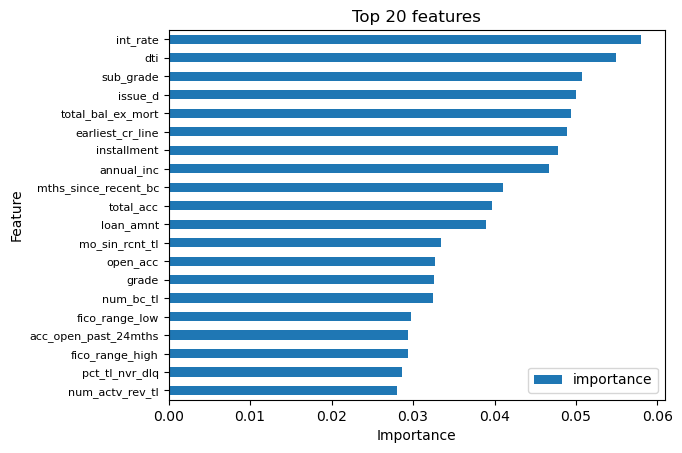

In [128]:

random_forest_ranking.iloc[-20:].plot(kind='barh',width= .5)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 features')
plt.yticks(fontsize=8)
plt.savefig("graphs/rand_forest_features.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

The model gives us a feature importance rating that depends on how often the feature is used and also on how far down a tree it is. We immediately see that it's chosing a different set of features compared to the linear models.

Sub grade is no longer the most important, even though it's still at the top. The top two became debt to income ratio and interest rate. In general features pertaining to the borrower income and financial history are ranked higher than the linear models.



### XGBOOST


In [53]:
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(objective = "binary:logistic",eval_metric = "auc", n_estimators = 15000, 
                              n_jobs = -1, random_state = 0)

xgboost_model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=15000, n_jobs=-1,
              num_parallel_tree=None, random_state=0, ...)

In [95]:
xgboost_yhat_val = xgboost_model.predict(X_val)
xgboost_phat_val = xgboost_model.predict_proba(X_val)[:,1]

print("accuracy: ", accuracy_score(y_val,xgboost_yhat_val))
print("jaccard score: ",jaccard_score(y_val, xgboost_yhat_val))
print(classification_report(y_val,xgboost_yhat_val))
xgboost_cm = pd.DataFrame(confusion_matrix(y_val, xgboost_yhat_val))
xgboost_cm.index.name="actual"
xgboost_cm.columns.name="predicted"
print(xgboost_cm)


accuracy:  0.6230046920855471
jaccard score:  0.24543919711110068
              precision    recall  f1-score   support

           0       0.88      0.62      0.73    275803
           1       0.29      0.64      0.39     65623

    accuracy                           0.62    341426
   macro avg       0.58      0.63      0.56    341426
weighted avg       0.76      0.62      0.66    341426

predicted       0       1
actual                   
0          170842  104961
1           23755   41868


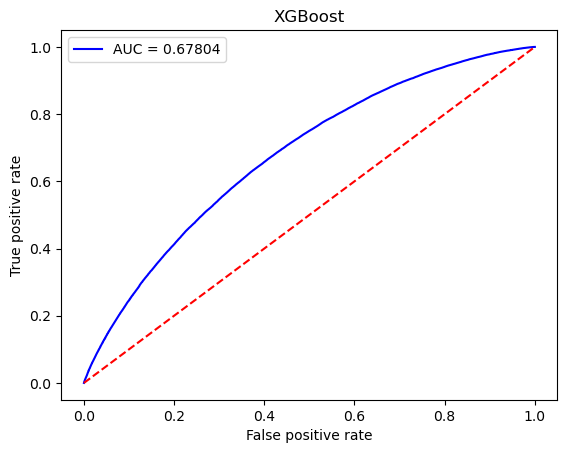

In [96]:
xgboost_fpr, xgboost_tpr, xgboost_thresholds = roc_curve(y_val, xgboost_phat_val)
xgboost_auc_val = roc_auc_score(y_val, xgboost_phat_val)
plt.plot(xgboost_fpr,xgboost_tpr, "b", label = "AUC = %0.5f"%xgboost_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("XGBoost")
plt.savefig("graphs/xgboost_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

This model is the worst performing one so far. It has a lower AUC than all the previous ones.

In [56]:

xgboost_ranking = pd.DataFrame({"feature":xgboost_model.feature_names_in_,
                                     "importance":xgboost_model.feature_importances_}).set_index("feature")
xgboost_ranking.sort_values("importance",inplace=True,ascending=True)

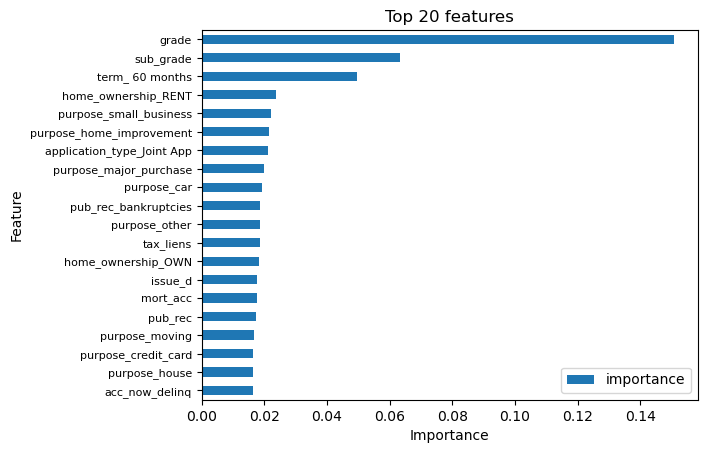

In [57]:
xgboost_ranking.iloc[-20:].plot(kind='barh',width= .5)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 features')
plt.yticks(fontsize=8)
plt.savefig("graphs/xgboost_features.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

This model, like random forest, is also harder to interpret than linear models.

The feature importance plot is however very interesting. Beside the loan grade, it's assigning high importance to features that don't have much information on the borrower's income or financial status. Income, loan amount and interest rate are not among the top 20 features by importance. The only feature that has some information on the loan conditions present in the top 20 is Term_60_months.

Most of the features near the top relate to the purpose of the loan or the home ownership status.


### BART


We preferred to use an R package for this model, as we did not like the python implementations that we found.

In [58]:
# we used R to fit the BART model

bart_phat_val = pd.read_csv("C:\\Users\\giuse\\DatiR\\lending_club\\bart_phat_val.csv",index_col= 0)
bart_phat_val.index = y_val.index
# bart_phat_val = np.random.shuffle(np.asarray(bart_phat_val.x))
bart_phat_val.head()

x
666509   0.615914
113669   0.364615
1034907  0.165571
1190916  0.568667
107094   0.545671

In [97]:
bart_yhat_val = bart_phat_val > 0.5

print("accuracy", accuracy_score(y_val,bart_yhat_val))
print("jaccard score: ",jaccard_score(y_val, bart_yhat_val))
print(classification_report(y_val,bart_yhat_val))
bart_cm = pd.DataFrame(confusion_matrix(y_val, bart_yhat_val))
bart_cm.index.name="actual"
bart_cm.columns.name="predicted"
print(bart_cm)


accuracy 0.6432462671266981
jaccard score:  0.2708208615694069
              precision    recall  f1-score   support

           0       0.90      0.63      0.74    275803
           1       0.31      0.69      0.43     65623

    accuracy                           0.64    341426
   macro avg       0.60      0.66      0.58    341426
weighted avg       0.78      0.64      0.68    341426

predicted       0       1
actual                   
0          174382  101421
1           20384   45239


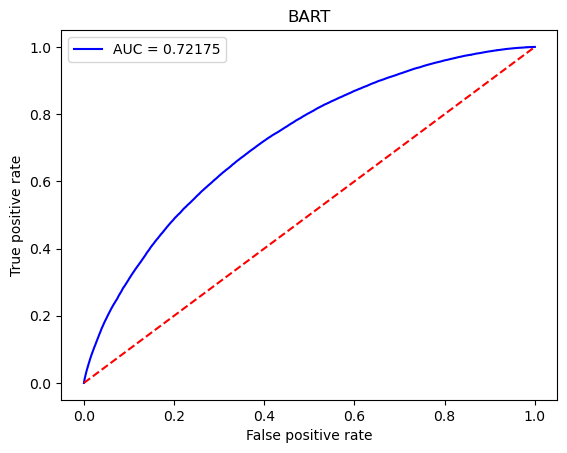

In [98]:
#Roc Curve
bart_fpr, bart_tpr, bart_thresholds = roc_curve(y_val, bart_phat_val)
bart_auc_val = roc_auc_score(y_val, bart_phat_val)
plt.plot(bart_fpr,bart_tpr, "b", label = "AUC = %0.5f"%bart_auc_val)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("BART")
plt.savefig("graphs/bart_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

This model's performance is more in line with Random Forest. It performs ever so slightly better than linear models by AUC. Also it is the one with the lowest number of false negatives.

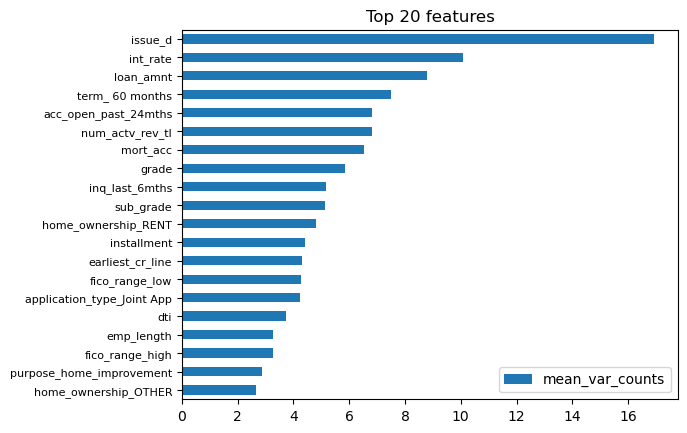

In [99]:

#feature importance

bart_mean_var_counts = pd.read_csv("C:\\Users\\giuse\\DatiR\\lending_club\\mean_var_counts.csv", index_col= 0)
bart_mean_var_counts.rename(columns={"x":"mean_var_counts"},inplace = True)
bart_mean_var_counts.rename(index= {"term_.60.months" : "term_ 60 months",
                                     "verification_status_Not.Verified" : "verification_status_Not Verified", 
                                     "application_type_Joint.App":"application_type_Joint App"}, inplace = True)


bart_mean_var_counts.sort_values(by= "mean_var_counts").iloc[-20:].plot(kind='barh')
plt.title('Top 20 features')
plt.yticks(fontsize=8)
plt.savefig("graphs/bart_features.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

The feature importance ranking is also interesting. We plotted the average number of times a feature is selected in a tree. The top one is issue_date, which is unexpected as all the previous models never ranked it near the top.

However the following ones are interest rate, loan amount and term_60_months.

## Model performance side by side

In [101]:
roc_auc_list = [logreg_auc_val, lassocv_auc_val, ridgecv_auc_val, elasticnetcv_auc_val, en_highreg_auc_val, random_forest_auc_val, xgboost_auc_val, bart_auc_val]

accuracy_list = [accuracy_score(y_val,model_yhat_val) for model_yhat_val in (logReg_yhat_val, lassocv_yhat_val, ridgecv_yhat_val, elasticnetcv_yhat_val, en_highreg_yhat_val, random_forest_yhat_val, xgboost_yhat_val, bart_yhat_val)]

jaccard_list = [jaccard_score(y_val,model_yhat_val) for model_yhat_val in (logReg_yhat_val, lassocv_yhat_val, ridgecv_yhat_val, elasticnetcv_yhat_val, en_highreg_yhat_val, random_forest_yhat_val, xgboost_yhat_val, bart_yhat_val)]

TP_list = [logreg_cm.loc[1,1], lassocv_cm.loc[1,1], ridgecv_cm.loc[1,1], elasticnetcv_cm.loc[1,1], en_highreg_cm.loc[1,1], random_forest_cm.loc[1,1], xgboost_cm.loc[1,1], bart_cm.loc[1,1]]

TN_list = [logreg_cm.loc[0,0], lassocv_cm.loc[0,0], ridgecv_cm.loc[0,0], elasticnetcv_cm.loc[0,0], en_highreg_cm.loc[0,0], random_forest_cm.loc[0,0], xgboost_cm.loc[0,0], bart_cm.loc[0,0]]

FP_list = [logreg_cm.loc[0,1], lassocv_cm.loc[0,1], ridgecv_cm.loc[0,1], elasticnetcv_cm.loc[0,1], en_highreg_cm.loc[0,1], random_forest_cm.loc[0,1], xgboost_cm.loc[0,1], bart_cm.loc[0,1]]

FN_list = [logreg_cm.loc[1,0], lassocv_cm.loc[1,0], ridgecv_cm.loc[1,0], elasticnetcv_cm.loc[1,0], en_highreg_cm.loc[1,0], random_forest_cm.loc[1,0], xgboost_cm.loc[1,0], bart_cm.loc[1,0]]

model_comparison = pd.DataFrame({"model":["Logistic Regression","LASSO","Ridge","Elastic Net","Elastic Net High","Random Forest","XGboost","Bart"],
              "ROC_AUC":roc_auc_list,
              "Accuracy":accuracy_list,
              "Jaccard" : jaccard_list,
              "True_Positives":TP_list,
              "True_Negatives":TN_list,
              "False_Positives":FP_list,
              "False_Negatives":FN_list}).set_index("model")

In [102]:
model_comparison

ROC_AUC  Accuracy   Jaccard  True_Positives  \
model                                                               
Logistic Regression  0.712924  0.656494  0.266726           42661   
LASSO                0.712897  0.656602  0.266623           42625   
Ridge                0.712924  0.656488  0.266737           42664   
Elastic Net          0.712895  0.656652  0.266711           42638   
Elastic Net High     0.706030  0.658154  0.261746           41381   
Random Forest        0.720287  0.645865  0.270891           44923   
XGboost              0.678044  0.623005  0.245439           41868   
Bart                 0.721746  0.643246  0.270821           45239   

                     True_Negatives  False_Positives  False_Negatives  
model                                                                  
Logistic Regression          181483            94320            22962  
LASSO                        181556            94247            22998  
Ridge                        181478            94325            22959  
Elastic Net                  181560            94243            22985  
Elastic Net High             183330            92473            24242  
Random Forest                175592           100211            20700  
XGboost                      170842           104961            23755  
Bart                         174382           101421            20384

This table gives us an immediate comparison of model performance as well as the confusion matrix

The metric we are more interested in is AUC, as accuracy and Jaccard score depend on the selected threshold, which in this case is the naive $0.5$

In our application however it's important to pick a threshold value that reflects the fact that false negatives present a greater problem than false positives.

The general trend is the following: Random forest and BART perform slightly better than linear models, hower this small improvement comes with a trade-off on model interpretability, which is more important in our analysis.

We can trade off for even more interpretability if we chose a higher regularization strenght for the linear models.


The following plot gives us a comparison of how small of a performance loss we incur by getting better interpretability. The x axis is scaled from $0.5$ to $1$ which are the upper and lower bounds of AUC.


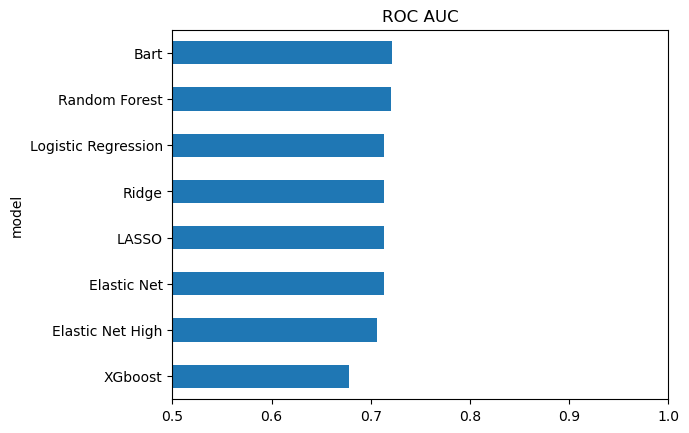

In [103]:
model_comparison.ROC_AUC.sort_values().plot(kind="barh")
plt.title("ROC AUC")
plt.xlim((0.5,1))
plt.savefig("graphs/AUC_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

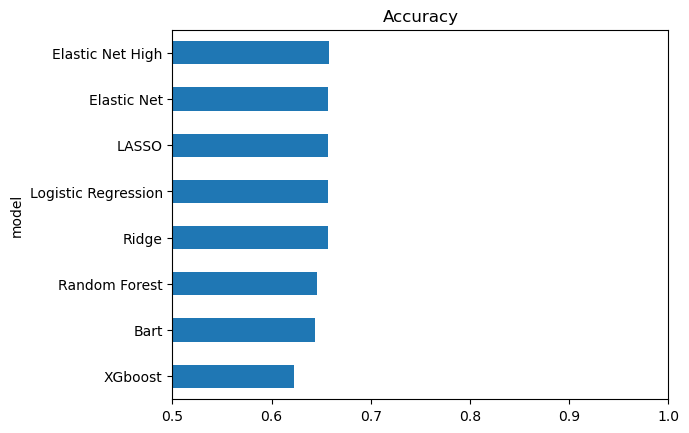

In [104]:
model_comparison.Accuracy.sort_values().plot(kind="barh")
plt.title("Accuracy")
plt.xlim((0.5,1))
plt.savefig("graphs/Accuracy_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

This accuracy plot is again scaled on the minimum and maximum values, however we believe that accuracy is not a good metric for comparing the models, as we have previously explained.

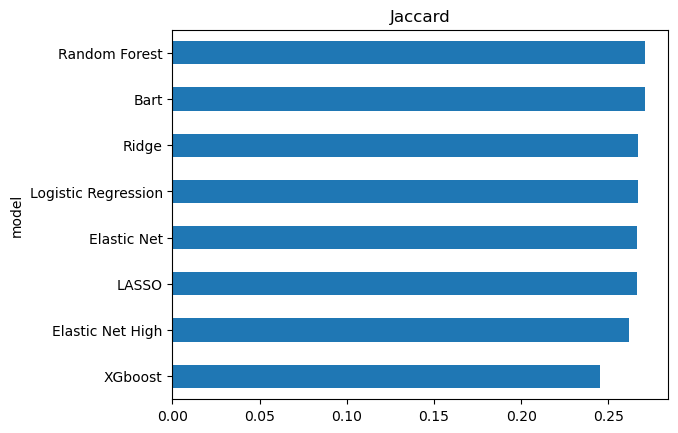

In [105]:
model_comparison.Jaccard.sort_values().plot(kind="barh")
plt.title("Jaccard")
# plt.xlim((0.5,1))
# plt.savefig("graphs/Accuracy_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

The jaccard score, just like the accuracy, suffers from the issue of not properly weighting false negatives and false positives.

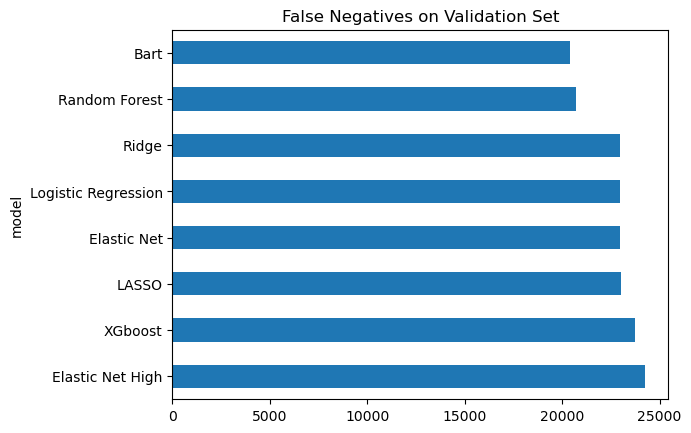

In [66]:
model_comparison.False_Negatives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Negatives on Validation Set")
plt.savefig("graphs/FN_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

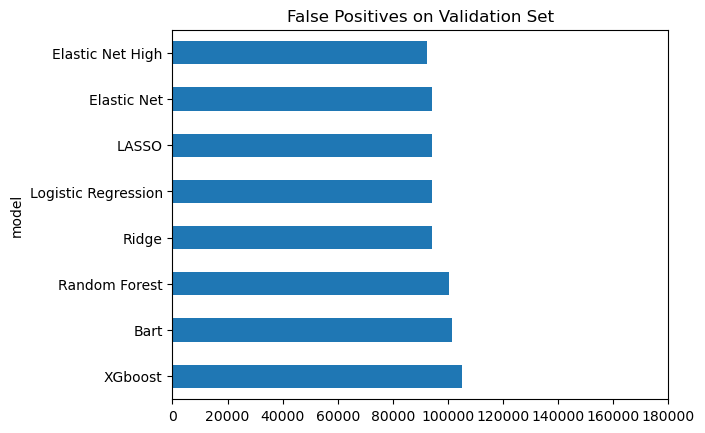

In [67]:
model_comparison.False_Positives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Positives on Validation Set")
plt.xlim((0,180000))
plt.savefig("graphs/FP_model_comparison.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')

plt.show()

### Selecting a threshold


In this application, we can assume that false negatives, i.e. type II errors, are much worse than false positives. A loan that defaults but is undetected by our model has worse consequences than a loan that doesn't default but our model doesn't like. We define a loss function to select a threshold that gives more weight to false negatives.

$\ell(\theta) = \theta\times FPR + (1-\theta)\times FNR$

Where $\theta$ is a parameter we set that allows us to make false negatives more costly. We pick $ 0.4$

In [68]:
def get_cm_given_theta(model_fpr, model_tpr, model_thresholds, model_phat, theta = 0.4, val = True):
    if val:
        y_true = y_val
    else:
        y_true = y_test
    ell = model_fpr * theta + (1-theta)*(1-model_tpr)
    lowest_ell = np.argmin(ell)
    optimal_threshold = model_thresholds[lowest_ell]
    cm_optimal_threshold = pd.DataFrame(confusion_matrix(y_true, model_phat > optimal_threshold))
    cm_optimal_threshold.index.name="actual"
    cm_optimal_threshold.columns.name="predicted"
    print("selected threshold is "+str(optimal_threshold))
    return cm_optimal_threshold

In [69]:
fprs = [logReg_fpr, lassocv_fpr, ridgecv_fpr, elasticnetcv_fpr, en_highreg_fpr, random_forest_fpr, xgboost_fpr, bart_fpr]
tprs = [logReg_tpr, lassocv_tpr, ridgecv_tpr, elasticnetcv_tpr, en_highreg_tpr, random_forest_tpr, xgboost_tpr, bart_tpr]
thresholds = [logReg_thresholds, lassocv_thresholds, ridgecv_thresholds, elasticnetcv_thresholds, en_highreg_thresholds, random_forest_thresholds, xgboost_thresholds, bart_thresholds]
phat_vals = [logreg_phat_val, lassocv_phat_val, ridgecv_phat_val, elasticnetcv_phat_val, en_highreg_phat_val, random_forest_phat_val, xgboost_phat_val, bart_phat_val]

In [70]:
optimal_t_cm = {model : get_cm_given_theta(fprs, tprs, t, phat) for model,fprs, tprs, t, phat in 
                zip(model_comparison.index,fprs, tprs, thresholds, phat_vals)}

selected threshold is 0.39072805657414594
selected threshold is 0.39284264541784275
selected threshold is 0.3908309143151089
selected threshold is 0.39305919799918704
selected threshold is 0.40087453597659733
selected threshold is 0.41533333333333333
selected threshold is 0.054599497
selected threshold is 0.409396398346668


The $\theta$ parameter we picked results in a lower threshold: all models except for XGBoost drop from $0.5$ to around $0.4$.

This means we will have more false positives: loans that get rejected because the risk of default is too high, even if they actually don't default.

But this is a fair tradeoff because we are able to detect many more loans that actually default but were previously liked by the model.

In [71]:
optimal_cm_sidebyside = pd.DataFrame({"model":["Logistic Regression","LASSO","Ridge","Elastic Net","Elastic Net High","Random Forest","XGboost","Bart"],
              "True_Positives":[optimal_t_cm[model].loc[1,1] for model in model_comparison.index],
              "True_Negatives":[optimal_t_cm[model].loc[0,0] for model in model_comparison.index],
              "False_Positives":[optimal_t_cm[model].loc[0,1] for model in model_comparison.index],
              "False_Negatives":[optimal_t_cm[model].loc[1,0] for model in model_comparison.index]}).set_index("model")
optimal_cm_sidebyside

True_Positives  True_Negatives  False_Positives  \
model                                                                  
Logistic Regression           54878          121438           154365   
LASSO                         54746          122423           153380   
Ridge                         54869          121490           154313   
Elastic Net                   54727          122513           153290   
Elastic Net High              55489          115686           160117   
Random Forest                 54425          127446           148357   
XGboost                       56173           99214           176589   
Bart                          54328          128916           146887   

                     False_Negatives  
model                                 
Logistic Regression            10745  
LASSO                          10877  
Ridge                          10754  
Elastic Net                    10896  
Elastic Net High               10134  
Random Forest                  11198  
XGboost                         9450  
Bart                           11295

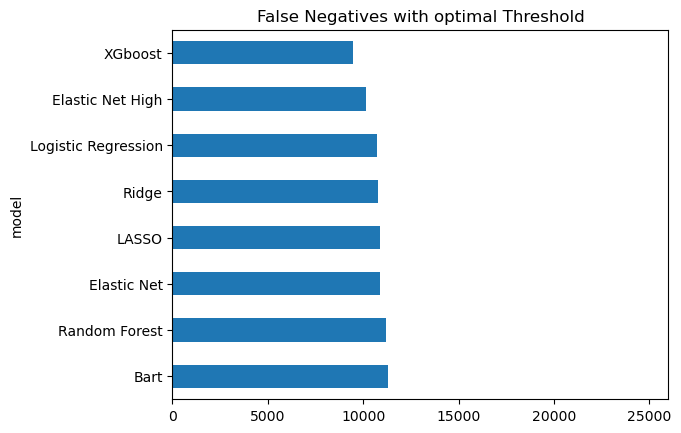

In [72]:
optimal_cm_sidebyside.False_Negatives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Negatives with optimal Threshold")
plt.xlim((0,26000))
plt.savefig("graphs/FN_optimal_T.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

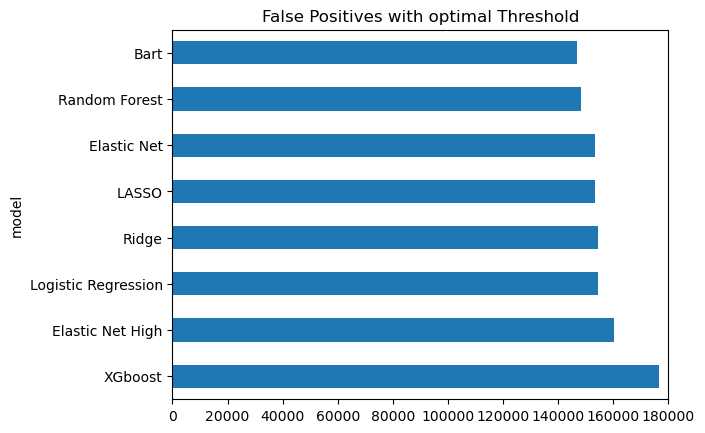

In [73]:
optimal_cm_sidebyside.False_Positives.sort_values(ascending=False).plot(kind="barh")
plt.title("False Positives with optimal Threshold")
plt.xlim((0,180000))
plt.savefig("graphs/FP_optimal_T.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

The table with the new confusion matrices and the graphs can be compared with the ones that were constructed with the naive threshold. The false negatives drop by around 50% for all models.

## Feature importance ranking


Do models agree on which features are the most important?

As we have already discussed the linear models all like the same features, but this changes for the tree based models.

We will use the rank() function to assign a rank that goes from 50 for the most important feature, to 1 for the least important.

First we have to take the absolute values of the coefficients of the linear models. This way negative coefficients that have a high absolute value can be compared with positive ones.

After assigning a ranking to feature importance we check how this ranking is correlated from model to model.

In [107]:
models_features_importance = [logreg_coeffs.apply(np.abs),
                            lassocv_coeffs.apply(np.abs),
                            ridgecv_coeffs.apply(np.abs),
                            elasticnetcv_coeffs.apply(np.abs),
                            en_highreg_coeffs.apply(np.abs),
                            random_forest_ranking,
                            xgboost_ranking, 
                            bart_mean_var_counts]

models_features_importance = [features.rank() for features in models_features_importance]

models_features_importance = pd.concat(models_features_importance,axis = "columns")
models_features_importance = models_features_importance.T
models_features_importance.index = model_comparison.index
models_features_importance=models_features_importance.T
models_features_importance.corr()

model                Logistic Regression     LASSO     Ridge  Elastic Net  \
model                                                                       
Logistic Regression             1.000000  0.967082  0.999712     0.967082   
LASSO                           0.967082  1.000000  0.970011     0.999616   
Ridge                           0.999712  0.970011  1.000000     0.970107   
Elastic Net                     0.967082  0.999616  0.970107     1.000000   
Elastic Net High                0.612299  0.590274  0.609809     0.590274   
Random Forest                   0.478319  0.489135  0.480528     0.494226   
XGboost                         0.127203  0.061850  0.121056     0.057720   
Bart                            0.494070  0.533698  0.493205     0.536291   

model                Elastic Net High  Random Forest   XGboost      Bart  
model                                                                     
Logistic Regression          0.612299       0.478319  0.127203  0.494070  
LASSO                        0.590274       0.489135  0.061850  0.533698  
Ridge                        0.609809       0.480528  0.121056  0.493205  
Elastic Net                  0.590274       0.494226  0.057720  0.536291  
Elastic Net High             1.000000       0.374601  0.258430  0.575817  
Random Forest                0.374601       1.000000 -0.232557  0.562257  
XGboost                      0.258430      -0.232557  1.000000  0.002737  
Bart                         0.575817       0.562257  0.002737  1.000000

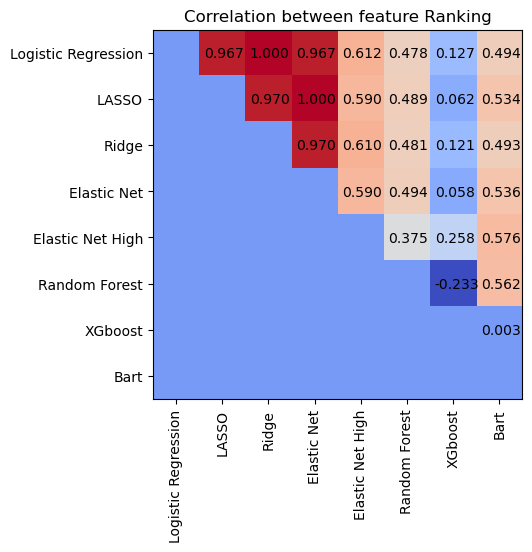

In [109]:
# Plotting the heat map of the correlation matrix
ranking_corr = models_features_importance.corr()
ranking_corr = ranking_corr* np.tri(8,k=-1).T
plt.imshow(ranking_corr,cmap = "coolwarm")
plt.xticks(range(8), ranking_corr, rotation = 90)
plt.yticks(range(8), ranking_corr)
for i in range(len(ranking_corr.index)):
    for j in range(len(ranking_corr.index)):
        if i < j :
            plt.text(j-0.4,i+0.1,"{:.3f}".format(ranking_corr.iloc[i,j]),size = 10)
plt.title("Correlation between feature Ranking")
plt.savefig("graphs/Corr_feature_rank.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

As expected, all the linear models, especially the ones with low regularization, strongly agree on which features matter more.

XGboost is the model that disagrees most with the others. It has near 0 correlation with all other models. Actually it is slightly negatively correlated with random forest. This is surprising, considering that the model's performance is worse but it remains as somewhat usable model.

We can infer that there must be many different patterns in the data which allow to detect default probabilty.

Interestingly the Elastic net model with high penalization, that is the model we used to trade off even more performance to gain more interpretability, has just as high correlation with BART as with the other linear models.

Now we select only the most important features, according to mean ranking and its economic meaning. We exclude from the mean the first two linear models, since they are higly correlated

In [76]:
models_features_importance.iloc[:,2:].mean(axis="columns").sort_values(ascending=False).head(10)

sub_grade               48.000000
term_ 60 months         44.333333
issue_d                 42.500000
home_ownership_RENT     41.166667
dti                     40.666667
acc_open_past_24mths    40.666667
mort_acc                40.333333
int_rate                38.500000
fico_range_high         35.666667
num_actv_rev_tl         35.666667
dtype: float64

## Fitting a new model with only the selected features

In [77]:
selected_features = ["int_rate","sub_grade", "term_ 60 months", "dti", "loan_amnt","fico_range_high",
                     "mort_acc","home_ownership_RENT", "home_ownership_OWN","issue_d",
                     'acc_open_past_24mths', 'num_actv_rev_tl']

Elastic net with selected features

We select the top 12 features according to insight gained by the previous models as well as domain knowledge on credit risk assesment and we fit an elastic net model.

We chose the Elastic Net model as we believe the interpretability value of linear coefficients is a key factor in this application.

We will test its performance on the test set that so far has not been used.

In [78]:
from sklearn.linear_model import LogisticRegressionCV
# parameter Cs= Each of the values in Cs describes the inverse of regularization strength.
# If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.
# Like in support vector machines, smaller values specify stronger regularization.
Cs=np.exp(np.arange(13,-1,step=-0.2))**-1

elasticnetcv_model_final = LogisticRegressionCV(penalty="elasticnet", solver="saga", Cs = Cs, cv = 5, 
                                          l1_ratios= [0.5], max_iter = 3500, n_jobs = -1,verbose = 0)
elasticnetcv_model_final.fit(X_train[selected_features],y_train)

LogisticRegressionCV(Cs=60, cv=5, l1_ratios=[0.5], max_iter=3500, n_jobs=-1,
                     penalty='elasticnet', solver='saga')

In [79]:
elasticnetcv_final_yhat_test = elasticnetcv_model_final.predict(X_test[selected_features])
elasticnetcv_final_phat_test = elasticnetcv_model_final.predict_proba(X_test[selected_features])[:,1]
print("num of coefs that have been shrunk to 0: ", (elasticnetcv_model_final.coef_ == 0).sum())
print("L1 norm of coefficients: ", np.abs(elasticnetcv_model_final.coef_).sum())
print("L2 norm of coefficients: ", (elasticnetcv_model_final.coef_**2).sum())
print("accuracy: ", accuracy_score(y_test,elasticnetcv_final_yhat_test))
print(classification_report(y_test,elasticnetcv_final_yhat_test))
elasticnetcv_final_cm = pd.DataFrame(confusion_matrix(y_test, elasticnetcv_final_yhat_test))
elasticnetcv_final_cm.index.name="actual"
elasticnetcv_final_cm.columns.name="predicted"
print(elasticnetcv_final_cm)
print("coefficients of Elastic net")
elasticnetcv_final_coeffs = (pd.Series(elasticnetcv_model_final.coef_[0], index = elasticnetcv_model_final.feature_names_in_)).sort_values()
elasticnetcv_final_coeffs

num of coefs that have been shrunk to 0:  0
L1 norm of coefficients:  2.0966343481679552
L2 norm of coefficients:  0.7474449040172003
accuracy:  0.6570552247863668
              precision    recall  f1-score   support

           0       0.89      0.66      0.76    295221
           1       0.31      0.64      0.42     70593

    accuracy                           0.66    365814
   macro avg       0.60      0.65      0.59    365814
weighted avg       0.77      0.66      0.69    365814

predicted       0       1
actual                   
0          195044  100177
1           25277   45316
coefficients of Elastic net


sub_grade              -0.728056
int_rate               -0.244489
fico_range_high        -0.165852
mort_acc               -0.135260
home_ownership_OWN      0.040139
num_actv_rev_tl         0.040289
loan_amnt               0.065649
issue_d                 0.066400
acc_open_past_24mths    0.116733
dti                     0.133565
home_ownership_RENT     0.138209
term_ 60 months         0.221993
dtype: float64

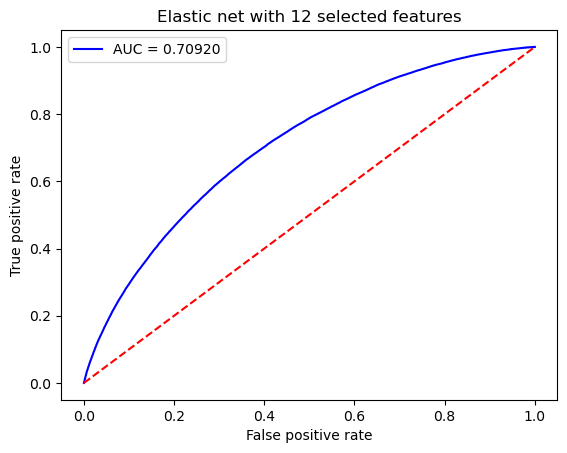

In [80]:
elasticnetcv_test_fpr, elasticnetcv_test_tpr, elasticnetcv_test_thresholds = roc_curve(y_test, elasticnetcv_final_phat_test)
elasticnetcv_test_auc_test = roc_auc_score(y_test, elasticnetcv_final_phat_test)
plt.plot(elasticnetcv_test_fpr,elasticnetcv_test_tpr, "b", label = "AUC = %0.5f"%elasticnetcv_test_auc_test)
plt.plot([0,1],[0,1],"r--")
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("Elastic net with 12 selected features")
plt.savefig("graphs/elastic_net_selected_roc.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

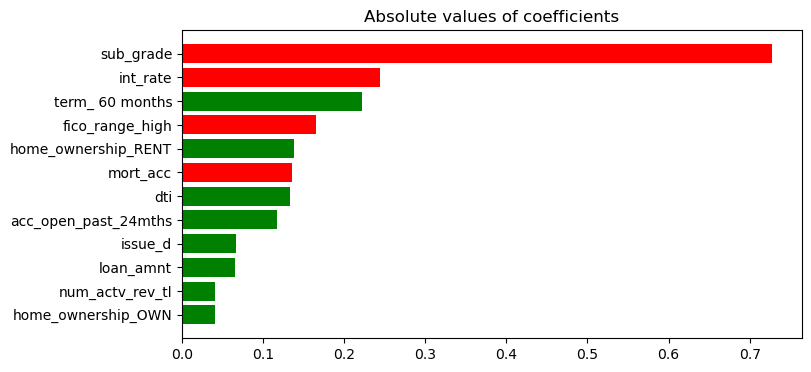

In [81]:
sorted_coeffs = elasticnetcv_final_coeffs
color_bars = np.where(sorted_coeffs < 0, "red","green")
sorted_coeffs = pd.DataFrame({"abs_value": np.abs(sorted_coeffs), "color":color_bars }).sort_values("abs_value")
sorted_coeffs = sorted_coeffs[sorted_coeffs.abs_value !=0]
fig, ax = plt.subplots(figsize = (8,4))
ax.barh(sorted_coeffs.index,sorted_coeffs.abs_value, color = sorted_coeffs.color)

ax.set_title("Absolute values of coefficients")
plt.savefig("graphs/elastic_net_selected_coeffs.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

126.38482029342971 	 this is the optimal lambda parameter


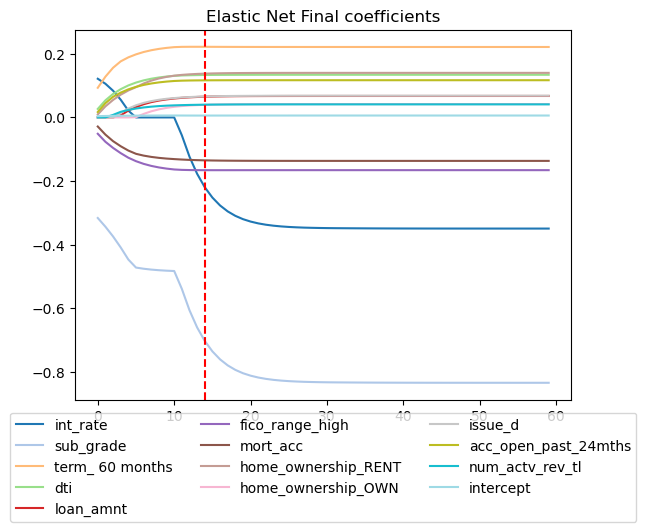

In [82]:
print((elasticnetcv_model_final.C_**-1)[0],"\t this is the optimal lambda parameter")
col_names = list(elasticnetcv_model_final.feature_names_in_)
pd.DataFrame(elasticnetcv_model_final.coefs_paths_[1][:,:,0,:].mean(axis=0),columns=col_names+["intercept"]).plot(linewidth=1.5,colormap="tab20")
plt.axvline(x=np.argmax(elasticnetcv_model_final.Cs_ == elasticnetcv_model_final.C_),linestyle="--",color="red")
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -.35),ncols=3)
plt.title("Elastic Net Final coefficients")
plt.savefig("graphs/elastic_net_selected_coeffs_paths.svg",facecolor = (1,1,1,0), transparent = True,bbox_inches='tight')
plt.show()

In [83]:
opt_t_cm_final = get_cm_given_theta(elasticnetcv_test_fpr, elasticnetcv_test_tpr, elasticnetcv_test_thresholds, elasticnetcv_final_phat_test, val = False)
opt_t_cm_final

selected threshold is 0.3888553574861238


predicted       0       1
actual                   
0          126195  169026
1           11381   59212